<a href="https://colab.research.google.com/github/johnryantaylor/QCES/blob/main/Project3_tsunami.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 3: Tsunami
In this project, we will use Dedalus to model the propagation of Tsunami waves. Tsunami typically have wavelengths larger than 100km and periods of about 1 hour. Since their wavelength is much larger than the depth of the ocean, Tsunami can be modelled using the shallow water equations.

Here, we will use Dedalus to solve an initial value problem for the shallow water equations. We will generate a Tsunami using a localized disturbance to the water height.

Student tasks are in [Section 1.3]( #section1pt3 ), [Section 2.3]( #section2pt3 ), and [Section 3.3]( #section3pt3 ).

## Setup
If you are using Google colab, run the script below to install Dedalus

In [17]:
# Set environment variables for best performance
%env OMP_NUM_THREADS=1
%env NUMEXPR_MAX_THREADS=1

# Minimize logging output
import logging
logging.disable(logging.DEBUG)

# Check if running on google colab
import os
using_google_colab = bool(os.getenv("COLAB_RELEASE_TAG"))

# Check for Dedalus
try:
    import dedalus.public as de
    print("Dedalus already installed :)")
except:
    print("Dedalus not installed yet.")
    if using_google_colab:
        print("Installing for Google Colab.")
        print()
        # Step 1: Install FFTW
        !apt-get install libfftw3-dev
        !apt-get install libfftw3-mpi-dev
        # Step 2: Set paths for Dedalus installation
        import os
        os.environ['MPI_INCLUDE_PATH'] = "/usr/lib/x86_64-linux-gnu/openmpi/include"
        os.environ['MPI_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        os.environ['FFTW_INCLUDE_PATH'] = "/usr/include"
        os.environ['FFTW_LIBRARY_PATH'] = "/usr/lib/x86_64-linux-gnu"
        # Step 3: Install Dedalus using pip
        !pip3 install cython "mpi4py<4.0" numpy setuptools wheel
        !CC=mpicc pip3 install --no-cache --no-build-isolation http://github.com/dedalusproject/dedalus/zipball/master/
        !pip3 install -q ipympl
        # Step 4: Check installation
        print()
        try:
            import dedalus.public as de
            print("Dedalus successfully installed :)")
        except:
            print("Error installing Dedalus :(")
            raise
    else:
        print("See website for installation instructions:")
        print("https://dedalus-project.readthedocs.io/en/latest/pages/installation.html")

# Setup interactive matplotlib
if using_google_colab:
    from google.colab import output
    output.enable_custom_widget_manager()

env: OMP_NUM_THREADS=1
env: NUMEXPR_MAX_THREADS=1
Dedalus already installed :)


## 1.  1D shallow water equations
Let's start by solving the shallow water equations in 1D with periodic boundary conditions in our spatial variable, $x$. The script below solves the following equations:

$$ \partial_t u + g \partial_x(h) = - u\partial_x u$$
$$ \partial_t h + \partial_x(Hu) = -\partial_x(hu)$$

In these equations, $g$ is the constant gravitational acceleration, $u$ is the velocity in the $x$ direction, $H$ is the resting height, and $h$ is the height of the free surface relative to $H$. Note that the terms on the right hand side are nonlinear in our dependent variables, and we will use an explicit timestepping method for these terms. Recall that Dedalus uses explicit timestepping for terms on the right hand side of the inputted equation.

Because we are interested in an application to Tsunami, we will solve the equations using dimensional variables. It is convenient to define simulation units at the start of the script so that we can be explicit about the units.

We will start with the following initial conditions:
$$ h=e^{-(x-x_1)^2/w_1^2} $$
$$ u=(c/g)h $$
where $x_1$ is the center and $w_1=100$ km is the width of the Gaussian perturbation. This generates a wave that will propagate to the right with speed $c$ before it encounters the seamount.

To see how the waves change as they approach shallow water, we will set the resting water depth to include a localized seamount using the form:
$$ H=H_0-(H_0-H_{min})e^{(-(x-x_2)^2/w_2^2)} $$
where $x_2$ is the location of the seamount, $H_0=4$ km is the depth of the ocean away from the seamount, and $H_{min}$ is the minimum water depth above the seamount. Note that since $H\ll w$, the shallow water approximation is appropriate here.

### 1.1  Dedalus script to solve the 1D shallow water equations

The script below solves the 1D shallow water equations with the initial conditions given above.

In [18]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size
Nx = 512 # The number of gridpoints in x
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
c = np.sqrt(g*H0) # Wave speed over the deep ocean
w1 = 20 * kilometer # Width of the initial perturbation
x1 = 200 * kilometer # Center of the initial perturbation
x2 = 500 * kilometer # Center of the seamount
w2 = 100 * kilometer # Width of the seamount
H_min = 100 * meter # minimum depth above the seamount

timestep = 60 * second # Specify the timestep
stop_sim_time = 100 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Create an x-coordinate, a corresponding basis, and a distributor
xcoord = dedalus.Coordinate('x')
dist = dedalus.Distributor(xcoord, dtype=np.float64) # No mesh for serial / automatic parallelization
x_basis = dedalus.RealFourier(xcoord, size=Nx, bounds=(0, Lx))
x = dist.local_grid(x_basis)

# Specify the Fields and set the initial conditions
u = dist.Field(name='u', bases=x_basis)
h = dist.Field(name='h', bases=x_basis)
H = dist.Field(name='H', bases=x_basis)
h.change_scales(1)
H.change_scales(1)
u.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-(x-x2)**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2.0/w1**2.0)  # Initialize the height with a Gaussian function with width set above
u['g'] = (g/c)*h['g']

# Operators
dx = lambda a: dedalus.Differentiate(a, xcoord)

# Problem
problem = dedalus.IVP([u, h], namespace=locals())
problem.add_equation("dt(u) + g*dx(h) = - u*dx(u)")
problem.add_equation("dt(h) + dx(H*u) = - dx(h*u)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

TypeError: 'numpy.ndarray' object is not callable

### 1.2  Plotting
The code below will make a movie of the height.

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-26 14:55:25,842 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpud1iv4r7/temp.m4v


2025-11-26 14:55:25,845 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpud1iv4r7/temp.m4v


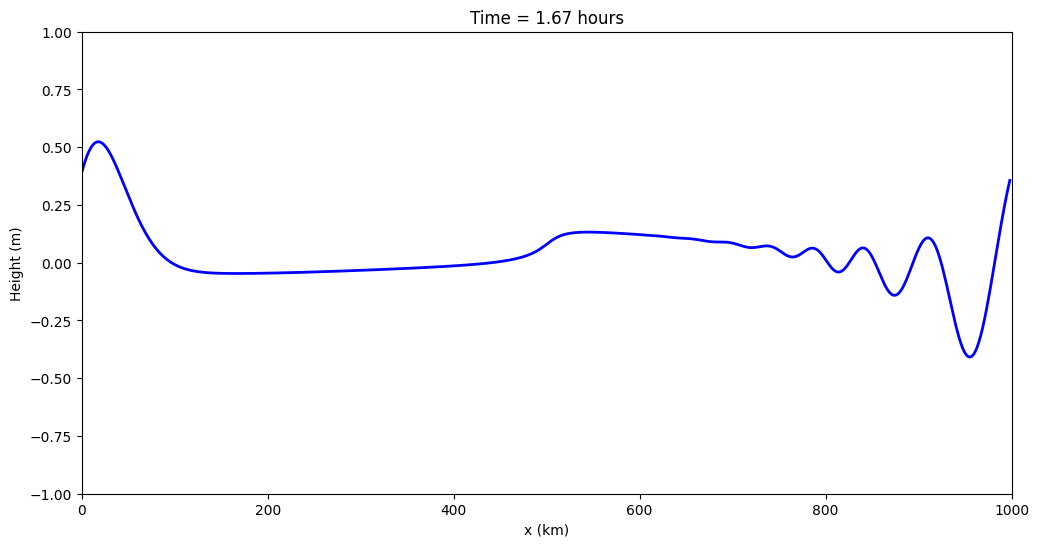

In [19]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Specify the axis limits and labels
plt.xlim((0, Lx / (1*kilometer)))
plt.ylim((-1, 1))
plt.xlabel('x (km)')
plt.ylabel('Height (m)')

# Create objects that will change during the animation
txt_title = plt.title('')
height, = plt.plot([], [], 'b', lw=2)

# Define an animation function
def drawframe(n):
    height.set_data(x/(1*kilometer), h_save[n,:])
    txt_title.set_text('Time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())


### 1.3 Student investigation
<a id='section1pt3'></a>
In the cells below, provide an expression for the expected wave speed and state any assumptions that are necessary to arrive at this. Then plot the wave speed from the output above and compare this with the expected value.

ADD EXPRESSION FOR EXPECTED WAVE SPEED AND EXPLANATION HERE

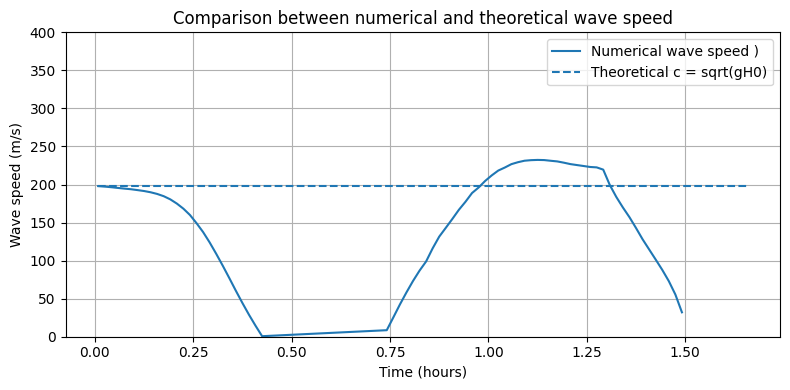

In [20]:
# CREATE FIGURES HERE

import numpy as np
import matplotlib.pyplot as plt

h_arr = np.array(h_save)
t_arr = np.array(t_save)
x_arr = x

h_pos = np.maximum(h_arr, 0.0)
weight_sum = np.sum(h_pos, axis=1)
x_peak = np.sum(h_pos * x_arr, axis=1) / weight_sum
t_peak = t_arr


dx = np.diff(x_peak)
dt = np.diff(t_peak)
c_num = dx / dt
t_mid = 0.5 * (t_peak[1:] + t_peak[:-1])

c_theory = np.sqrt(g*H0)

good = (c_num > 0) & (c_num < 1000)

plt.figure(figsize=(8,4))

plt.plot(t_mid[good] / hour, c_num[good],
         label='Numerical wave speed )')

plt.hlines(c_theory, t_mid[0]/hour, t_mid[-1]/hour,
           linestyles='--', label='Theoretical c = sqrt(gH0)')

plt.xlabel('Time (hours)')
plt.ylabel('Wave speed (m/s)')
plt.title('Comparison between numerical and theoretical wave speed')
plt.legend()
plt.grid(True)

plt.ylim(0, 400)

plt.tight_layout()
plt.show()



COMMENT ON RESULTS

## 2.  2D Shallow water equations

Now, let's see how things change if we move to two dimensions. The script below solves the 2D shallow water equations:

$$ \partial_t u + g \partial_x(h) = - u*\partial_x u - v*\partial_y u$$
$$ \partial_t u + g \partial_y(h) = - u*\partial_x v - v*\partial_y v$$
$$ \partial_t h + \partial_x(u*H) + \partial_y(v*H)) = -\partial_x(h*u) - \partial_y(h*v)$$

We will initilize the Tsunami with the following equation
$$ h=e^{-x^2/w_1^2} $$
$$ u=(g/c)*h $$

where $c=\sqrt{gH_0}$ and $H_0$ is the constant reference depth. The relationship between $u$ and $h$ follows from linearized shallow water equations and corresponds to a wave propagating in the $+x$ direction with a speed $c$.

We will solve the equations in a square domain with periodic boundary conditions and a Gaussian seamount in the middle of the domain with total undisturbed fluid height

$$ H=H_0 - (H_0 - H_{min})e^{-(x^2+y^2)/w_2^2} $$

The Tsunami should propagate with speed $c$ over the deep ocean where the depth is constant, but the wave will be modified as it passes over the seamount.

### 2.1  Dedalus script to solve the 2D shallow water equations

In [22]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Specify the simulation parameters
Lx = 1000 * kilometer # The domain size in x
Ly = 1000 * kilometer # The domain size in y
Nx = 64 # The number of gridpoints in x
Ny = 64 # The number of gridpoints in y
g = 9.81 * meter / second**2 # Gravitational acceleration
H0 = 4 * kilometer # Reference ocean depth
c = np.sqrt(g*H0) # Wave speed over the deep ocean
H_min = 1 * kilometer # minimum depth above the seamount
w1 = 50 * kilometer # Set the width of the wave
w2 = 200 * kilometer # Width of the seamount
x1 = -300 * kilometer # Center of the wave at t=0

timestep = 60 * second # Specify the timestep
stop_sim_time = 60 * minute # Specify the stopping time

timestepper = dedalus.RK222
max_timestep = 0.125

# Bases
coords = dedalus.CartesianCoordinates('x', 'y')
dist = dedalus.Distributor(coords, dtype=np.float64)
xbasis = dedalus.RealFourier(coords['x'], size=Nx, bounds=(-Lx/2, Lx/2), dealias=3/2)
ybasis = dedalus.RealFourier(coords['y'], size=Ny, bounds=(-Ly/2, Ly/2), dealias=3/2)

x, y = dist.local_grids(xbasis, ybasis)

# Fields
u = dist.Field(name='u', bases=(xbasis, ybasis))
v = dist.Field(name='v', bases=(xbasis, ybasis))
h = dist.Field(name='h', bases=(xbasis, ybasis))
H = dist.Field(name='H', bases=(xbasis, ybasis))

# Initial conditions
H.change_scales(1)
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
v.change_scales(1)
H['g'] = H0-(H0-H_min)*np.exp(-x**2.0/w2**2.0 - y**2.0/w2**2.0)
h['g'] = np.exp(-(x-x1)**2/w1**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
u['g'] = (g/c)*h['g']
v['g'] = 0

# Operators
Dx = lambda a: dedalus.Differentiate(a, coords['x'])
Dy = lambda a: dedalus.Differentiate(a, coords['y'])

# Problem
problem = dedalus.IVP(
    [u, v, h],
    namespace={
        'u': u, 'v': v, 'h': h, 'H': H,
        'g': g,
        'Dx': Dx, 'Dy': Dy
    }
)

problem.add_equation("dt(u) + g*Dx(h) = - u*Dx(u) - v*Dy(u)")
problem.add_equation("dt(v) + g*Dy(h) = - u*Dx(v) - v*Dy(v)")
problem.add_equation("dt(h) + (Dx(H*u) + Dy(H*v)) = - Dx(h*u) - Dy(h*v)")

# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

# Analysis
snapshots = solver.evaluator.add_file_handler('snapshots', sim_dt=1*hour, max_writes=10)
snapshots.add_task(h, name='h')
snapshots.add_task(u, name='u')
snapshots.add_task(v, name='v')

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 1 == 0:
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save=np.array(h_save) # convert h_save to an np.array type to allow data slicing

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 14s, Remaining: 0s, Rate: 7.3e-02/s


2025-11-26 15:08:57,067 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 14s, Remaining: 0s, Rate: 7.3e-02/s


INFO:__main__:Starting main loop


2025-11-26 15:08:57,074 __main__ 0/1 INFO :: Starting main loop


INFO:solvers:Simulation stop time reached.


2025-11-26 15:09:03,664 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 60


2025-11-26 15:09:03,666 solvers 0/1 INFO :: Final iteration: 60


INFO:solvers:Final sim time: 3600.0


2025-11-26 15:09:03,667 solvers 0/1 INFO :: Final sim time: 3600.0


INFO:solvers:Setup time (init - iter 0): 13.8 sec


2025-11-26 15:09:03,669 solvers 0/1 INFO :: Setup time (init - iter 0): 13.8 sec


INFO:solvers:Warmup time (iter 0-10): 4.22 sec


2025-11-26 15:09:03,670 solvers 0/1 INFO :: Warmup time (iter 0-10): 4.22 sec


INFO:solvers:Run time (iter 10-end): 2.368 sec


2025-11-26 15:09:03,671 solvers 0/1 INFO :: Run time (iter 10-end): 2.368 sec


INFO:solvers:CPU time (iter 10-end): 0.0006576 cpu-hr


2025-11-26 15:09:03,673 solvers 0/1 INFO :: CPU time (iter 10-end): 0.0006576 cpu-hr


INFO:solvers:Speed: 5.029e+05 mode-stages/cpu-sec


2025-11-26 15:09:03,675 solvers 0/1 INFO :: Speed: 5.029e+05 mode-stages/cpu-sec


### 2.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-26 15:12:57,926 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpbjh4hkju/temp.m4v


2025-11-26 15:12:57,927 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 600x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpbjh4hkju/temp.m4v


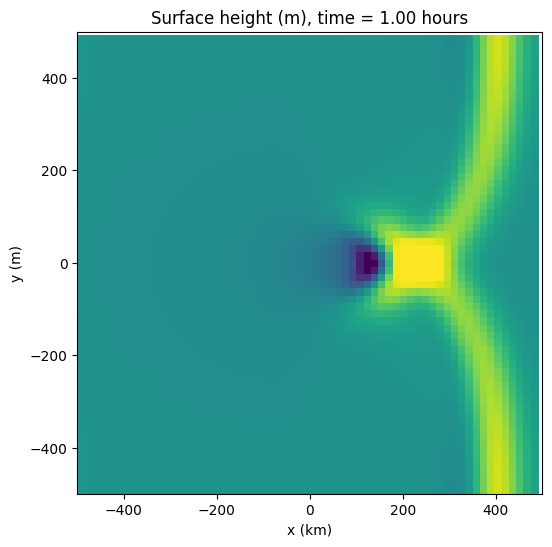

In [23]:
# create a figure and axes
fig = plt.figure(figsize=(6,6))

# Create arrays with the x and y coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

# Define an animation function
def drawframe(n):
    plt.clf # clear the figure before plotting the next frame
    height = plt.pcolor(X/(1*kilometer), Y/(1*kilometer), h_save[n,:,:].T, vmin=-1, vmax=1)
    # Specify the axis limits and labels
    plt.xlim((-Lx/2 / (1*kilometer),Lx/2 / (1*kilometer)))
    plt.ylim((-Ly/2 / (1*kilometer),Ly/2 / (1*kilometer)))
    plt.xlabel('x (km)')
    plt.ylabel('y (m)')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 2.3 Student investigation
<a id='section2pt3'></a>
Qualitatively describe the influence of the seamount and explain this behavior using the shallow water equations. You can assume that the wave amplitude and velocity are small in the shallow water equations.

STUDENT ANSWER HERE (~ 1 PARAGRAPH)

Try varying some parameters (e.g. the width and height of the wave and/or seamount) and comment on the results. When does the wave no longer obey the linear shallow water equations which are valid for small waves You don't need to do a comprehensive parameter space search, but you should run several simulations with one or two parameters varied.

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 11s, Remaining: 0s, Rate: 9.0e-02/s


2025-11-26 16:59:39,475 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 11s, Remaining: 0s, Rate: 9.0e-02/s


INFO:solvers:Simulation stop time reached.


2025-11-26 16:59:45,497 solvers 0/1 INFO :: Simulation stop time reached.


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 10s, Remaining: 0s, Rate: 9.7e-02/s


2025-11-26 16:59:55,808 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 10s, Remaining: 0s, Rate: 9.7e-02/s


INFO:solvers:Simulation stop time reached.


2025-11-26 17:00:01,942 solvers 0/1 INFO :: Simulation stop time reached.


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 9s, Remaining: 0s, Rate: 1.1e-01/s


2025-11-26 17:00:11,188 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 9s, Remaining: 0s, Rate: 1.1e-01/s


INFO:solvers:Simulation stop time reached.


2025-11-26 17:00:17,211 solvers 0/1 INFO :: Simulation stop time reached.


/tmp/ipython-input-1424145287.py:82: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


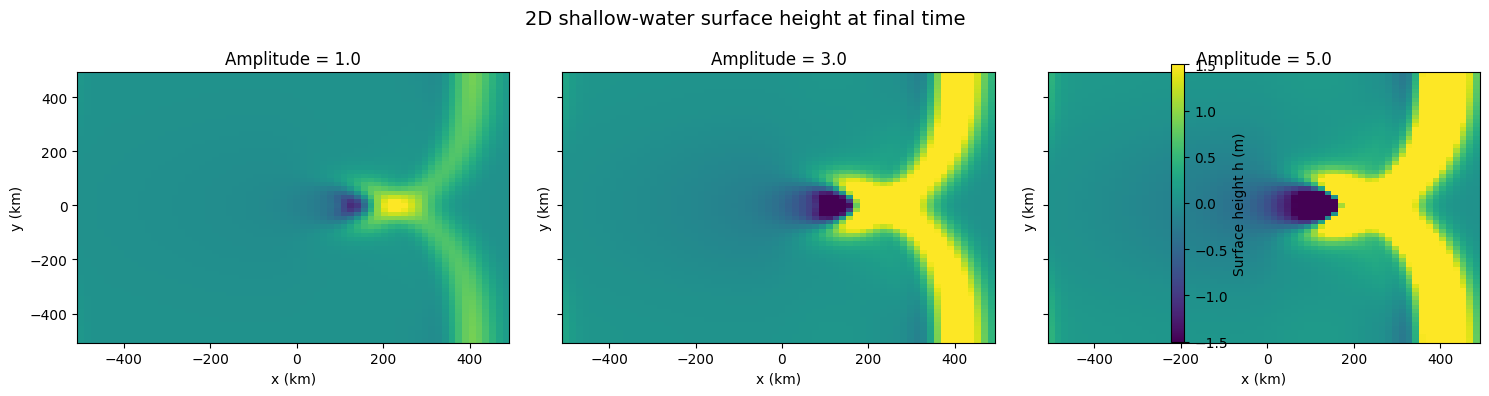

INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 7.7e-01/s


2025-11-26 17:00:19,125 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 7.7e-01/s


INFO:solvers:Simulation stop time reached.


2025-11-26 17:00:29,281 solvers 0/1 INFO :: Simulation stop time reached.


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 9s, Remaining: 0s, Rate: 1.1e-01/s


2025-11-26 17:00:38,024 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 9s, Remaining: 0s, Rate: 1.1e-01/s


INFO:solvers:Simulation stop time reached.


2025-11-26 17:00:44,871 solvers 0/1 INFO :: Simulation stop time reached.


INFO:subsystems:Building subproblem matrices 1/1 (~100%) Elapsed: 15s, Remaining: 0s, Rate: 6.8e-02/s


2025-11-26 17:00:59,631 subsystems 0/1 INFO :: Building subproblem matrices 1/1 (~100%) Elapsed: 15s, Remaining: 0s, Rate: 6.8e-02/s


INFO:solvers:Simulation stop time reached.


2025-11-26 17:01:06,510 solvers 0/1 INFO :: Simulation stop time reached.


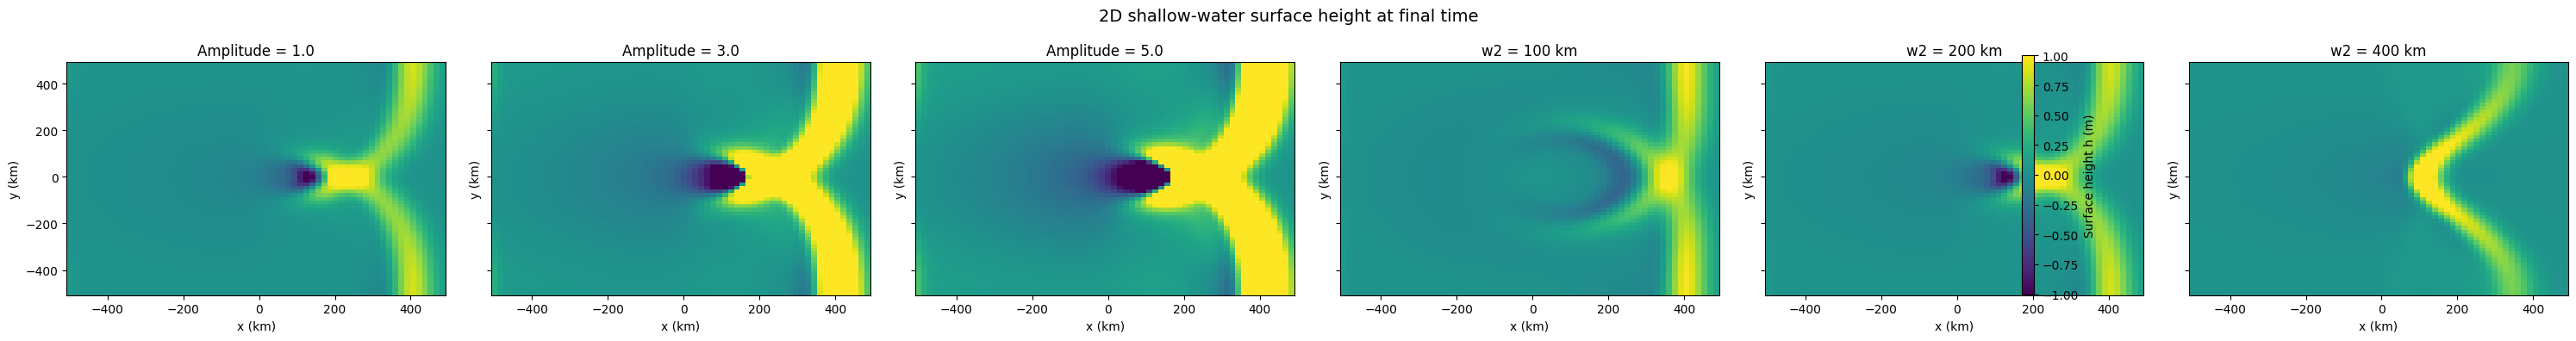

In [28]:
# ADD CODE AND PLOTS HERE
from dedalus.extras import plot_tools

def run_case(wave_amplitude=1.0,
             w1=50*kilometer,
             H_min=1*kilometer,
             w2=200*kilometer,
             label=''):

    u = dist.Field(name='u', bases=(xbasis, ybasis))
    v = dist.Field(name='v', bases=(xbasis, ybasis))
    h = dist.Field(name='h', bases=(xbasis, ybasis))
    H = dist.Field(name='H', bases=(xbasis, ybasis))

    H.change_scales(1)
    h.change_scales(1)
    u.change_scales(1)
    v.change_scales(1)

    H['g'] = H0 - (H0 - H_min) * np.exp(-x**2/w2**2 - y**2/w2**2)

    h['g'] = wave_amplitude * np.exp(-(x - x1)**2 / w1**2)
    u['g'] = (g/c) * h['g']
    v['g'] = 0

    Dx = lambda a: dedalus.Differentiate(a, coords['x'])
    Dy = lambda a: dedalus.Differentiate(a, coords['y'])

    problem = dedalus.IVP(
        [u, v, h],
        namespace={'u': u, 'v': v, 'h': h, 'H': H,
                   'g': g, 'Dx': Dx, 'Dy': Dy}
    )

    problem.add_equation("dt(u) + g*Dx(h) = - u*Dx(u) - v*Dy(u)")
    problem.add_equation("dt(v) + g*Dy(h) = - u*Dx(v) - v*Dy(v)")
    problem.add_equation("dt(h) + (Dx(H*u) + Dy(H*v)) = - Dx(h*u) - Dy(h*v)")

    solver = problem.build_solver(dedalus.RK222)
    solver.stop_sim_time = stop_sim_time

    h_save = [np.copy(h['g'])]
    t_save = [solver.sim_time]

    while solver.proceed:
        solver.step(timestep)
        h.change_scales(1)
        h_save.append(np.copy(h['g']))
        t_save.append(solver.sim_time)

    h_save = np.array(h_save)
    t_save = np.array(t_save)

    if label == '':
        label = f"A={wave_amplitude}, w1={w1/1000:.0f}km, Hmin={H_min/1000:.1f}km, w2={w2/1000:.0f}km"

    return h_save, t_save, label
def plot_2d_final(cases, vmax=1.0):

    X, Y = plot_tools.quad_mesh(np.squeeze(x), np.squeeze(y))

    ncase = len(cases)
    fig, axes = plt.subplots(1, ncase, figsize=(5*ncase, 4),
                             sharex=True, sharey=True)

    if ncase == 1:
        axes = [axes]

    for ax, (h_save, t_save, label) in zip(axes, cases):
        h_final = h_save[-1, :, :]
        im = ax.pcolormesh(X/(1*kilometer), Y/(1*kilometer),
                           h_final.T,
                           vmin=-vmax, vmax=vmax,
                           shading='auto')
        ax.set_xlabel('x (km)')
        ax.set_ylabel('y (km)')
        ax.set_title(label)

    fig.suptitle("2D shallow-water surface height at final time", fontsize=14)
    cbar = fig.colorbar(im, ax=axes, shrink=0.9)
    cbar.set_label('Surface height h (m)')
    plt.tight_layout()
    plt.show()
cases = []

for A in [1.0, 3.0, 5.0]:
    h_save, t_save, label = run_case(wave_amplitude=A,
                                     w1=50*kilometer,
                                     H_min=1*kilometer,
                                     w2=200*kilometer,
                                     label=f"Amplitude = {A}")
    cases.append((h_save, t_save, label))

plot_2d_final(cases, vmax=1.5)

for w in [100*kilometer, 200*kilometer, 400*kilometer]:
    h_save, t_save, label = run_case(wave_amplitude=1.0,
                                     w1=50*kilometer,
                                     H_min=1*kilometer,
                                     w2=w,
                                     label=f"w2 = {w/1000:.0f} km")
    cases.append((h_save, t_save, label))

plot_2d_final(cases, vmax=1.0)

STUDENT ANSWER HERE (~ 1 PARAGRAPH)

## 3. Shallow water equations on a sphere

Of course the Earth isn't a flat plane. A great strength of Dedalus is its flexibility to solve equations in various geometries. The script below solves the 2D shallow water equations on a spherical shell, where the azimuth and colatitude are the independent variables. The colatitude is the complementary angle to the latitude such that the colatitude is $0^\circ$ at the North Pole, $90^\circ$ at the Equator, and $180^\circ$ at the South Pole. The spherical geometry also allows us to take into account the Earth's rotation in a realistic way. In this part of the project, we will assume that the bottom of the ocean is flat and that the resting height of the ocean is a constant $H$.  

We will use Dedalus to solve the following equations:
$$ \partial_t \mathbf{u} + g \nabla h + 2 \Omega \hat{\mathbf{z}} \times \mathbf{u} = -\mathbf{u} \cdot \nabla \mathbf{u} $$
$$ \partial_t + H \nabla \cdot \mathbf{u} = -\nabla \cdot (h \mathbf{u}) $$

where $\mathbf{u}$ is the velocity vector, $\Omega$ is the Earth's angular velocity (in radians per second), and $\hat{\mathbf{z}}$ is a unit vector aligned with the North Pole. Note that we have written the equations above in vector form. Dedalus includes vector calculus operators that make it very natural to solve equations like this without worrying about the particular form of the vector operators in a curvilinear coordinate system.

### 3.1  Dedalus script for 2D shallow water equations on a sphere

In [30]:
# Import the required packages
import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

logger = logging.getLogger(__name__)

# Define the simulation units. This is optional, but will help us keep track of units
meter = 1
kilometer = meter * 1e3
second = 1
minute = 60
hour = 3600
day = hour * 24

# Parameters
Nphi = 128 # Number of gridpoints in phi (longitude)
Ntheta = 64 # Number of gridpoints in theta (colatitude)
R = 6.37122e3 * kilometer
Omega = 2 * np.pi / (1 * day) # Earth's angular velocity in radians per second
g = 9.80616 * meter / second**2 # Gravitational acceleration
H = 4 * kilometer # Depth of the ocean
width = 2*np.pi*10/360 # Width of the initial Gaussian in radians
phi0 = np.pi # Longitude of the initial Gaussian height perturbation in radians
theta0 = np.pi/4 # Colatitude of the initial Gaussian height perturbation in radians

timestep = 600 * second
stop_sim_time = 10 * day

# Bases
coords = dedalus.S2Coordinates('phi', 'theta')
dist = dedalus.Distributor(coords, dtype=np.float64)
basis = dedalus.SphereBasis(coords, (Nphi, Ntheta), radius=R, dealias=3/2, dtype=np.float64)

# Define the coordinates
phi, theta = dist.local_grids(basis) # Longitude and colatitude
lat = 360*(np.pi / 2 - theta)/(2*np.pi)  # latitude in degrees

# Fields
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)

# Operators
# First, create an operator to perform the cross product: "z x ", where z is the local vertical unit vector
# The "skew" operator performs a 90 degree rotation of a vector field,
# so that skew([u,v]) = [-v, u].  MulCosine multiplies by the cosine of the latitude
Grad   = lambda A: dedalus.grad(A)
Div    = lambda A: dedalus.div(A)
Zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))
# Set the initial conditions
h.change_scales(1) # Set values on regular grid
u.change_scales(1)
h['g'] = np.exp(-((phi-phi0)**2+(theta-theta0)**2)/width**2)  # Initialize the dependent variable c with a Gaussian function (note ** is the exponentiation operator)
# Set the initial velocity to zero
u['g'][0] = 0 # the x-component of the velocity
u['g'][1] = 0 # the y-component of the velocity

# Problem
problem = dedalus.IVP(
    [u, h],
    namespace={
        'u': u, 'h': h,
        'g': g, 'H': H,
        'Omega': Omega,
        'Grad': Grad,
        'Div': Div,
        'Zcross': Zcross
    }
)

problem.add_equation("dt(u) + g*Grad(h) + 2*Omega*Zcross(u) = - u@Grad(u)")
problem.add_equation("dt(h) + H*Div(u) = - Div(h*u)")
# Solver
solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]; t_save = [solver.sim_time]; # Save the initial condition and the initial time
# Main loop
try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        if (solver.iteration-1) % 10 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e' %(solver.iteration, solver.sim_time, timestep))
            h.change_scales(1)
            h_save.append(np.copy(h['g']))
            t_save.append(solver.sim_time)
except:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 3.9e+01/s


2025-11-26 17:23:45,040 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 2s, Rate: 3.9e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 5.9e+01/s


2025-11-26 17:23:45,132 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 5.9e+01/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 6.4e+01/s


2025-11-26 17:23:45,233 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 1s, Rate: 6.4e+01/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 6.5e+01/s


2025-11-26 17:23:45,335 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 1s, Rate: 6.5e+01/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 1s, Rate: 6.4e+01/s


2025-11-26 17:23:45,452 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 1s, Rate: 6.4e+01/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 0s, Rate: 6.5e+01/s


2025-11-26 17:23:45,556 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 1s, Remaining: 0s, Rate: 6.5e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 6.5e+01/s


2025-11-26 17:23:45,660 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 0s, Rate: 6.5e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 6.4e+01/s


2025-11-26 17:23:45,784 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 1s, Remaining: 0s, Rate: 6.4e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 6.4e+01/s


2025-11-26 17:23:45,895 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 6.4e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 6.4e+01/s


2025-11-26 17:23:45,999 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 6.4e+01/s


INFO:__main__:Starting main loop


2025-11-26 17:23:46,004 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2025-11-26 17:23:48,935 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=11, Time=6.600000e+03, dt=6.000000e+02


2025-11-26 17:23:49,490 __main__ 0/1 INFO :: Iteration=11, Time=6.600000e+03, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2025-11-26 17:23:49,777 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=31, Time=1.860000e+04, dt=6.000000e+02


2025-11-26 17:23:50,091 __main__ 0/1 INFO :: Iteration=31, Time=1.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2025-11-26 17:23:50,402 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=51, Time=3.060000e+04, dt=6.000000e+02


2025-11-26 17:23:50,708 __main__ 0/1 INFO :: Iteration=51, Time=3.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2025-11-26 17:23:51,023 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=71, Time=4.260000e+04, dt=6.000000e+02


2025-11-26 17:23:51,333 __main__ 0/1 INFO :: Iteration=71, Time=4.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2025-11-26 17:23:51,638 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=91, Time=5.460000e+04, dt=6.000000e+02


2025-11-26 17:23:51,956 __main__ 0/1 INFO :: Iteration=91, Time=5.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2025-11-26 17:23:52,267 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=111, Time=6.660000e+04, dt=6.000000e+02


2025-11-26 17:23:52,567 __main__ 0/1 INFO :: Iteration=111, Time=6.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2025-11-26 17:23:52,863 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=131, Time=7.860000e+04, dt=6.000000e+02


2025-11-26 17:23:53,190 __main__ 0/1 INFO :: Iteration=131, Time=7.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2025-11-26 17:23:53,485 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=151, Time=9.060000e+04, dt=6.000000e+02


2025-11-26 17:23:53,802 __main__ 0/1 INFO :: Iteration=151, Time=9.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2025-11-26 17:23:54,183 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=171, Time=1.026000e+05, dt=6.000000e+02


2025-11-26 17:23:54,569 __main__ 0/1 INFO :: Iteration=171, Time=1.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2025-11-26 17:23:54,932 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=191, Time=1.146000e+05, dt=6.000000e+02


2025-11-26 17:23:55,317 __main__ 0/1 INFO :: Iteration=191, Time=1.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2025-11-26 17:23:55,699 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=211, Time=1.266000e+05, dt=6.000000e+02


2025-11-26 17:23:56,000 __main__ 0/1 INFO :: Iteration=211, Time=1.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2025-11-26 17:23:56,319 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=231, Time=1.386000e+05, dt=6.000000e+02


2025-11-26 17:23:56,620 __main__ 0/1 INFO :: Iteration=231, Time=1.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2025-11-26 17:23:56,966 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=251, Time=1.506000e+05, dt=6.000000e+02


2025-11-26 17:23:57,342 __main__ 0/1 INFO :: Iteration=251, Time=1.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2025-11-26 17:23:57,713 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=271, Time=1.626000e+05, dt=6.000000e+02


2025-11-26 17:23:58,077 __main__ 0/1 INFO :: Iteration=271, Time=1.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2025-11-26 17:23:58,474 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=291, Time=1.746000e+05, dt=6.000000e+02


2025-11-26 17:23:58,848 __main__ 0/1 INFO :: Iteration=291, Time=1.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2025-11-26 17:23:59,325 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=311, Time=1.866000e+05, dt=6.000000e+02


2025-11-26 17:23:59,862 __main__ 0/1 INFO :: Iteration=311, Time=1.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2025-11-26 17:24:00,450 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=331, Time=1.986000e+05, dt=6.000000e+02


2025-11-26 17:24:00,899 __main__ 0/1 INFO :: Iteration=331, Time=1.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2025-11-26 17:24:01,258 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=351, Time=2.106000e+05, dt=6.000000e+02


2025-11-26 17:24:01,639 __main__ 0/1 INFO :: Iteration=351, Time=2.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2025-11-26 17:24:02,003 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=371, Time=2.226000e+05, dt=6.000000e+02


2025-11-26 17:24:02,393 __main__ 0/1 INFO :: Iteration=371, Time=2.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2025-11-26 17:24:02,777 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=391, Time=2.346000e+05, dt=6.000000e+02


2025-11-26 17:24:03,105 __main__ 0/1 INFO :: Iteration=391, Time=2.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2025-11-26 17:24:03,439 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=411, Time=2.466000e+05, dt=6.000000e+02


2025-11-26 17:24:03,737 __main__ 0/1 INFO :: Iteration=411, Time=2.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2025-11-26 17:24:04,067 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=431, Time=2.586000e+05, dt=6.000000e+02


2025-11-26 17:24:04,469 __main__ 0/1 INFO :: Iteration=431, Time=2.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2025-11-26 17:24:04,839 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=451, Time=2.706000e+05, dt=6.000000e+02


2025-11-26 17:24:05,221 __main__ 0/1 INFO :: Iteration=451, Time=2.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2025-11-26 17:24:05,611 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=471, Time=2.826000e+05, dt=6.000000e+02


2025-11-26 17:24:05,982 __main__ 0/1 INFO :: Iteration=471, Time=2.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=481, Time=2.886000e+05, dt=6.000000e+02


2025-11-26 17:24:06,348 __main__ 0/1 INFO :: Iteration=481, Time=2.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=491, Time=2.946000e+05, dt=6.000000e+02


2025-11-26 17:24:06,738 __main__ 0/1 INFO :: Iteration=491, Time=2.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=501, Time=3.006000e+05, dt=6.000000e+02


2025-11-26 17:24:07,091 __main__ 0/1 INFO :: Iteration=501, Time=3.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=511, Time=3.066000e+05, dt=6.000000e+02


2025-11-26 17:24:07,399 __main__ 0/1 INFO :: Iteration=511, Time=3.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=521, Time=3.126000e+05, dt=6.000000e+02


2025-11-26 17:24:07,716 __main__ 0/1 INFO :: Iteration=521, Time=3.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=531, Time=3.186000e+05, dt=6.000000e+02


2025-11-26 17:24:08,014 __main__ 0/1 INFO :: Iteration=531, Time=3.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=541, Time=3.246000e+05, dt=6.000000e+02


2025-11-26 17:24:08,417 __main__ 0/1 INFO :: Iteration=541, Time=3.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=551, Time=3.306000e+05, dt=6.000000e+02


2025-11-26 17:24:08,766 __main__ 0/1 INFO :: Iteration=551, Time=3.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=561, Time=3.366000e+05, dt=6.000000e+02


2025-11-26 17:24:09,083 __main__ 0/1 INFO :: Iteration=561, Time=3.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=571, Time=3.426000e+05, dt=6.000000e+02


2025-11-26 17:24:09,492 __main__ 0/1 INFO :: Iteration=571, Time=3.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=581, Time=3.486000e+05, dt=6.000000e+02


2025-11-26 17:24:09,805 __main__ 0/1 INFO :: Iteration=581, Time=3.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=591, Time=3.546000e+05, dt=6.000000e+02


2025-11-26 17:24:10,107 __main__ 0/1 INFO :: Iteration=591, Time=3.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=601, Time=3.606000e+05, dt=6.000000e+02


2025-11-26 17:24:10,418 __main__ 0/1 INFO :: Iteration=601, Time=3.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=611, Time=3.666000e+05, dt=6.000000e+02


2025-11-26 17:24:10,803 __main__ 0/1 INFO :: Iteration=611, Time=3.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=621, Time=3.726000e+05, dt=6.000000e+02


2025-11-26 17:24:11,267 __main__ 0/1 INFO :: Iteration=621, Time=3.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=631, Time=3.786000e+05, dt=6.000000e+02


2025-11-26 17:24:11,734 __main__ 0/1 INFO :: Iteration=631, Time=3.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=641, Time=3.846000e+05, dt=6.000000e+02


2025-11-26 17:24:12,197 __main__ 0/1 INFO :: Iteration=641, Time=3.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=651, Time=3.906000e+05, dt=6.000000e+02


2025-11-26 17:24:12,561 __main__ 0/1 INFO :: Iteration=651, Time=3.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=661, Time=3.966000e+05, dt=6.000000e+02


2025-11-26 17:24:12,952 __main__ 0/1 INFO :: Iteration=661, Time=3.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=671, Time=4.026000e+05, dt=6.000000e+02


2025-11-26 17:24:13,298 __main__ 0/1 INFO :: Iteration=671, Time=4.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=681, Time=4.086000e+05, dt=6.000000e+02


2025-11-26 17:24:13,616 __main__ 0/1 INFO :: Iteration=681, Time=4.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=691, Time=4.146000e+05, dt=6.000000e+02


2025-11-26 17:24:13,937 __main__ 0/1 INFO :: Iteration=691, Time=4.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=701, Time=4.206000e+05, dt=6.000000e+02


2025-11-26 17:24:14,277 __main__ 0/1 INFO :: Iteration=701, Time=4.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=711, Time=4.266000e+05, dt=6.000000e+02


2025-11-26 17:24:14,674 __main__ 0/1 INFO :: Iteration=711, Time=4.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=721, Time=4.326000e+05, dt=6.000000e+02


2025-11-26 17:24:15,068 __main__ 0/1 INFO :: Iteration=721, Time=4.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=731, Time=4.386000e+05, dt=6.000000e+02


2025-11-26 17:24:15,404 __main__ 0/1 INFO :: Iteration=731, Time=4.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=741, Time=4.446000e+05, dt=6.000000e+02


2025-11-26 17:24:15,712 __main__ 0/1 INFO :: Iteration=741, Time=4.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=751, Time=4.506000e+05, dt=6.000000e+02


2025-11-26 17:24:16,028 __main__ 0/1 INFO :: Iteration=751, Time=4.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=761, Time=4.566000e+05, dt=6.000000e+02


2025-11-26 17:24:16,336 __main__ 0/1 INFO :: Iteration=761, Time=4.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=771, Time=4.626000e+05, dt=6.000000e+02


2025-11-26 17:24:16,629 __main__ 0/1 INFO :: Iteration=771, Time=4.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=781, Time=4.686000e+05, dt=6.000000e+02


2025-11-26 17:24:16,938 __main__ 0/1 INFO :: Iteration=781, Time=4.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=791, Time=4.746000e+05, dt=6.000000e+02


2025-11-26 17:24:17,249 __main__ 0/1 INFO :: Iteration=791, Time=4.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=801, Time=4.806000e+05, dt=6.000000e+02


2025-11-26 17:24:17,646 __main__ 0/1 INFO :: Iteration=801, Time=4.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=811, Time=4.866000e+05, dt=6.000000e+02


2025-11-26 17:24:18,051 __main__ 0/1 INFO :: Iteration=811, Time=4.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=821, Time=4.926000e+05, dt=6.000000e+02


2025-11-26 17:24:18,442 __main__ 0/1 INFO :: Iteration=821, Time=4.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=831, Time=4.986000e+05, dt=6.000000e+02


2025-11-26 17:24:18,820 __main__ 0/1 INFO :: Iteration=831, Time=4.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=841, Time=5.046000e+05, dt=6.000000e+02


2025-11-26 17:24:19,233 __main__ 0/1 INFO :: Iteration=841, Time=5.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=851, Time=5.106000e+05, dt=6.000000e+02


2025-11-26 17:24:19,591 __main__ 0/1 INFO :: Iteration=851, Time=5.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=861, Time=5.166000e+05, dt=6.000000e+02


2025-11-26 17:24:19,992 __main__ 0/1 INFO :: Iteration=861, Time=5.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=871, Time=5.226000e+05, dt=6.000000e+02


2025-11-26 17:24:20,366 __main__ 0/1 INFO :: Iteration=871, Time=5.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=881, Time=5.286000e+05, dt=6.000000e+02


2025-11-26 17:24:20,668 __main__ 0/1 INFO :: Iteration=881, Time=5.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=891, Time=5.346000e+05, dt=6.000000e+02


2025-11-26 17:24:20,981 __main__ 0/1 INFO :: Iteration=891, Time=5.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=901, Time=5.406000e+05, dt=6.000000e+02


2025-11-26 17:24:21,285 __main__ 0/1 INFO :: Iteration=901, Time=5.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=911, Time=5.466000e+05, dt=6.000000e+02


2025-11-26 17:24:21,584 __main__ 0/1 INFO :: Iteration=911, Time=5.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=921, Time=5.526000e+05, dt=6.000000e+02


2025-11-26 17:24:21,884 __main__ 0/1 INFO :: Iteration=921, Time=5.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=931, Time=5.586000e+05, dt=6.000000e+02


2025-11-26 17:24:22,279 __main__ 0/1 INFO :: Iteration=931, Time=5.586000e+05, dt=6.000000e+02


INFO:__main__:Iteration=941, Time=5.646000e+05, dt=6.000000e+02


2025-11-26 17:24:22,719 __main__ 0/1 INFO :: Iteration=941, Time=5.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=951, Time=5.706000e+05, dt=6.000000e+02


2025-11-26 17:24:23,170 __main__ 0/1 INFO :: Iteration=951, Time=5.706000e+05, dt=6.000000e+02


INFO:__main__:Iteration=961, Time=5.766000e+05, dt=6.000000e+02


2025-11-26 17:24:23,606 __main__ 0/1 INFO :: Iteration=961, Time=5.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=971, Time=5.826000e+05, dt=6.000000e+02


2025-11-26 17:24:23,896 __main__ 0/1 INFO :: Iteration=971, Time=5.826000e+05, dt=6.000000e+02


INFO:__main__:Iteration=981, Time=5.886000e+05, dt=6.000000e+02


2025-11-26 17:24:24,215 __main__ 0/1 INFO :: Iteration=981, Time=5.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=991, Time=5.946000e+05, dt=6.000000e+02


2025-11-26 17:24:24,538 __main__ 0/1 INFO :: Iteration=991, Time=5.946000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


2025-11-26 17:24:24,910 __main__ 0/1 INFO :: Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


2025-11-26 17:24:25,308 __main__ 0/1 INFO :: Iteration=1011, Time=6.066000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


2025-11-26 17:24:25,631 __main__ 0/1 INFO :: Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


2025-11-26 17:24:25,920 __main__ 0/1 INFO :: Iteration=1031, Time=6.186000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


2025-11-26 17:24:26,232 __main__ 0/1 INFO :: Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


2025-11-26 17:24:26,535 __main__ 0/1 INFO :: Iteration=1051, Time=6.306000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


2025-11-26 17:24:26,831 __main__ 0/1 INFO :: Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


2025-11-26 17:24:27,144 __main__ 0/1 INFO :: Iteration=1071, Time=6.426000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


2025-11-26 17:24:27,447 __main__ 0/1 INFO :: Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


2025-11-26 17:24:27,791 __main__ 0/1 INFO :: Iteration=1091, Time=6.546000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


2025-11-26 17:24:28,178 __main__ 0/1 INFO :: Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


2025-11-26 17:24:28,548 __main__ 0/1 INFO :: Iteration=1111, Time=6.666000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


2025-11-26 17:24:28,930 __main__ 0/1 INFO :: Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


2025-11-26 17:24:29,327 __main__ 0/1 INFO :: Iteration=1131, Time=6.786000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


2025-11-26 17:24:29,704 __main__ 0/1 INFO :: Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


2025-11-26 17:24:30,066 __main__ 0/1 INFO :: Iteration=1151, Time=6.906000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


2025-11-26 17:24:30,471 __main__ 0/1 INFO :: Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


2025-11-26 17:24:30,845 __main__ 0/1 INFO :: Iteration=1171, Time=7.026000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


2025-11-26 17:24:31,224 __main__ 0/1 INFO :: Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


2025-11-26 17:24:31,605 __main__ 0/1 INFO :: Iteration=1191, Time=7.146000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


2025-11-26 17:24:31,986 __main__ 0/1 INFO :: Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


2025-11-26 17:24:32,372 __main__ 0/1 INFO :: Iteration=1211, Time=7.266000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


2025-11-26 17:24:32,720 __main__ 0/1 INFO :: Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


2025-11-26 17:24:33,013 __main__ 0/1 INFO :: Iteration=1231, Time=7.386000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


2025-11-26 17:24:33,334 __main__ 0/1 INFO :: Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


2025-11-26 17:24:33,731 __main__ 0/1 INFO :: Iteration=1251, Time=7.506000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


2025-11-26 17:24:34,174 __main__ 0/1 INFO :: Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


2025-11-26 17:24:34,655 __main__ 0/1 INFO :: Iteration=1271, Time=7.626000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


2025-11-26 17:24:35,046 __main__ 0/1 INFO :: Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


2025-11-26 17:24:35,357 __main__ 0/1 INFO :: Iteration=1291, Time=7.746000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


2025-11-26 17:24:35,684 __main__ 0/1 INFO :: Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


2025-11-26 17:24:35,984 __main__ 0/1 INFO :: Iteration=1311, Time=7.866000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


2025-11-26 17:24:36,276 __main__ 0/1 INFO :: Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


2025-11-26 17:24:36,586 __main__ 0/1 INFO :: Iteration=1331, Time=7.986000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


2025-11-26 17:24:36,914 __main__ 0/1 INFO :: Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


2025-11-26 17:24:37,269 __main__ 0/1 INFO :: Iteration=1351, Time=8.106000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


2025-11-26 17:24:37,638 __main__ 0/1 INFO :: Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


2025-11-26 17:24:38,023 __main__ 0/1 INFO :: Iteration=1371, Time=8.226000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


2025-11-26 17:24:38,408 __main__ 0/1 INFO :: Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


2025-11-26 17:24:38,815 __main__ 0/1 INFO :: Iteration=1391, Time=8.346000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


2025-11-26 17:24:39,198 __main__ 0/1 INFO :: Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


2025-11-26 17:24:39,612 __main__ 0/1 INFO :: Iteration=1411, Time=8.466000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


2025-11-26 17:24:39,953 __main__ 0/1 INFO :: Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


2025-11-26 17:24:40,264 __main__ 0/1 INFO :: Iteration=1431, Time=8.586000e+05, dt=6.000000e+02


INFO:solvers:Simulation stop time reached.


2025-11-26 17:24:40,543 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2025-11-26 17:24:40,545 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2025-11-26 17:24:40,547 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 1.019 sec


2025-11-26 17:24:40,549 solvers 0/1 INFO :: Setup time (init - iter 0): 1.019 sec


INFO:solvers:Warmup time (iter 0-10): 3.456 sec


2025-11-26 17:24:40,552 solvers 0/1 INFO :: Warmup time (iter 0-10): 3.456 sec


INFO:solvers:Run time (iter 10-end): 51.08 sec


2025-11-26 17:24:40,553 solvers 0/1 INFO :: Run time (iter 10-end): 51.08 sec


INFO:solvers:CPU time (iter 10-end): 0.01419 cpu-hr


2025-11-26 17:24:40,556 solvers 0/1 INFO :: CPU time (iter 10-end): 0.01419 cpu-hr


INFO:solvers:Speed: 6.769e+05 mode-stages/cpu-sec


2025-11-26 17:24:40,557 solvers 0/1 INFO :: Speed: 6.769e+05 mode-stages/cpu-sec


### 3.2  Plotting
The code below will make a movie of the height as a function of x and y

INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-26 17:25:37,120 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpkoxuctf1/temp.m4v


2025-11-26 17:25:37,122 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmpkoxuctf1/temp.m4v


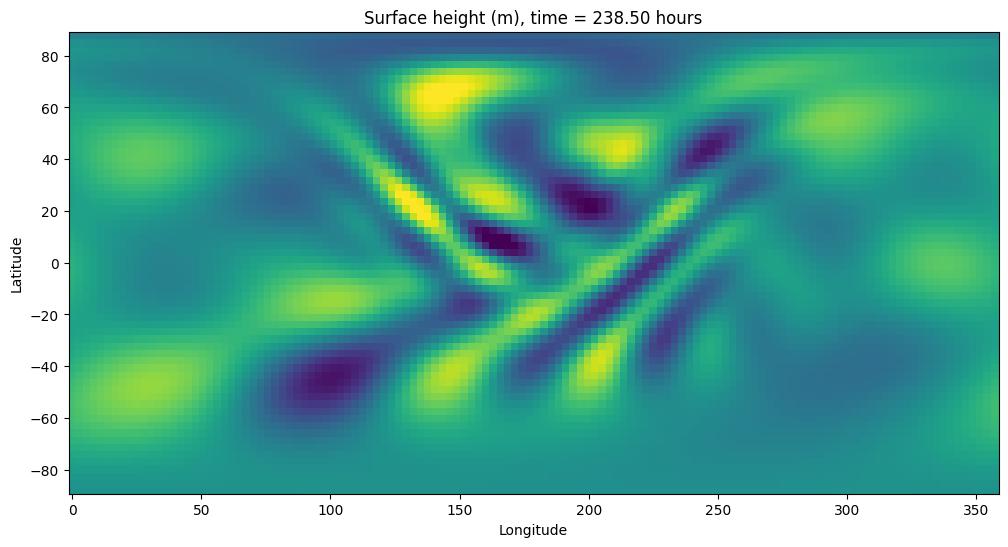

In [31]:
# create a figure and axes
fig = plt.figure(figsize=(12,6))

# Create arrays with the latitude and longitude coordinates for plotting using pcolor
from dedalus.extras import plot_tools
(X, Y) = plot_tools.quad_mesh(np.squeeze(np.pi/2 - theta)*360/2/np.pi, np.squeeze(phi)*360/2/np.pi)

# Define an animation function
def drawframe(n):
    plt.clf()
    height = plt.pcolor(Y, X, h_save[n,:,:], vmin=-0.1, vmax=0.1)
    # Specify the axis limits and labels
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.title('Surface height (m), time = {0:.2f} hours'.format(t_save[n]/(1*hour)))
    return (height,)

from matplotlib import animation
# blit=True re-draws only the parts that have changed.
anim = animation.FuncAnimation(fig, drawframe, frames=len(t_save), interval=40, blit=True)

from IPython.display import HTML
HTML(anim.to_html5_video())

### 3.3 Student investigation
<a id='section3pt3'></a>
Create a virtual tide gauge by sampling the height at a point at a latitude of 45ºN and longitude of 90ºW and plot the timeseries of the height at this point in the cells below. You should modifty the code to save the height more often so that you can clearly see the shape of the wave. Notice that as the waves propagate around the Earth, their shape changes. Discuss physical mechanisms that might cause the shape of the wave to change as the wave propagates.

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 8.2e+01/s


2025-11-26 17:56:14,253 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 8.2e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 1.1e+02/s


2025-11-26 17:56:14,307 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 1.1e+02/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s


2025-11-26 17:56:14,374 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


2025-11-26 17:56:14,446 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


2025-11-26 17:56:14,521 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 9.9e+01/s


2025-11-26 17:56:14,594 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 9.9e+01/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


2025-11-26 17:56:14,662 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


2025-11-26 17:56:14,729 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 0s, Remaining: 0s, Rate: 1.0e+02/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 1.0e+02/s


2025-11-26 17:56:14,796 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 1s, Remaining: 0s, Rate: 1.0e+02/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.0e+02/s


2025-11-26 17:56:14,867 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.0e+02/s


INFO:__main__:Starting main loop


Gauge indices (i_lon, j_lat): 96 48
Gauge actual location  (lat, lon) = 46.044726631101675 270.0
2025-11-26 17:56:14,872 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iteration=1, Time=6.000000e+02, dt=6.000000e+02


2025-11-26 17:56:18,084 __main__ 0/1 INFO :: Iteration=1, Time=6.000000e+02, dt=6.000000e+02


INFO:__main__:Iteration=21, Time=1.260000e+04, dt=6.000000e+02


2025-11-26 17:56:18,870 __main__ 0/1 INFO :: Iteration=21, Time=1.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=41, Time=2.460000e+04, dt=6.000000e+02


2025-11-26 17:56:19,594 __main__ 0/1 INFO :: Iteration=41, Time=2.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=61, Time=3.660000e+04, dt=6.000000e+02


2025-11-26 17:56:20,254 __main__ 0/1 INFO :: Iteration=61, Time=3.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=81, Time=4.860000e+04, dt=6.000000e+02


2025-11-26 17:56:20,904 __main__ 0/1 INFO :: Iteration=81, Time=4.860000e+04, dt=6.000000e+02


INFO:__main__:Iteration=101, Time=6.060000e+04, dt=6.000000e+02


2025-11-26 17:56:21,527 __main__ 0/1 INFO :: Iteration=101, Time=6.060000e+04, dt=6.000000e+02


INFO:__main__:Iteration=121, Time=7.260000e+04, dt=6.000000e+02


2025-11-26 17:56:22,159 __main__ 0/1 INFO :: Iteration=121, Time=7.260000e+04, dt=6.000000e+02


INFO:__main__:Iteration=141, Time=8.460000e+04, dt=6.000000e+02


2025-11-26 17:56:22,800 __main__ 0/1 INFO :: Iteration=141, Time=8.460000e+04, dt=6.000000e+02


INFO:__main__:Iteration=161, Time=9.660000e+04, dt=6.000000e+02


2025-11-26 17:56:23,463 __main__ 0/1 INFO :: Iteration=161, Time=9.660000e+04, dt=6.000000e+02


INFO:__main__:Iteration=181, Time=1.086000e+05, dt=6.000000e+02


2025-11-26 17:56:24,271 __main__ 0/1 INFO :: Iteration=181, Time=1.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=201, Time=1.206000e+05, dt=6.000000e+02


2025-11-26 17:56:24,962 __main__ 0/1 INFO :: Iteration=201, Time=1.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=221, Time=1.326000e+05, dt=6.000000e+02


2025-11-26 17:56:25,595 __main__ 0/1 INFO :: Iteration=221, Time=1.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=241, Time=1.446000e+05, dt=6.000000e+02


2025-11-26 17:56:26,236 __main__ 0/1 INFO :: Iteration=241, Time=1.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=261, Time=1.566000e+05, dt=6.000000e+02


2025-11-26 17:56:26,852 __main__ 0/1 INFO :: Iteration=261, Time=1.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=281, Time=1.686000e+05, dt=6.000000e+02


2025-11-26 17:56:27,645 __main__ 0/1 INFO :: Iteration=281, Time=1.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=301, Time=1.806000e+05, dt=6.000000e+02


2025-11-26 17:56:28,652 __main__ 0/1 INFO :: Iteration=301, Time=1.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=321, Time=1.926000e+05, dt=6.000000e+02


2025-11-26 17:56:29,363 __main__ 0/1 INFO :: Iteration=321, Time=1.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=341, Time=2.046000e+05, dt=6.000000e+02


2025-11-26 17:56:30,001 __main__ 0/1 INFO :: Iteration=341, Time=2.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=361, Time=2.166000e+05, dt=6.000000e+02


2025-11-26 17:56:30,673 __main__ 0/1 INFO :: Iteration=361, Time=2.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=381, Time=2.286000e+05, dt=6.000000e+02


2025-11-26 17:56:31,318 __main__ 0/1 INFO :: Iteration=381, Time=2.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=401, Time=2.406000e+05, dt=6.000000e+02


2025-11-26 17:56:31,937 __main__ 0/1 INFO :: Iteration=401, Time=2.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=421, Time=2.526000e+05, dt=6.000000e+02


2025-11-26 17:56:32,574 __main__ 0/1 INFO :: Iteration=421, Time=2.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=441, Time=2.646000e+05, dt=6.000000e+02


2025-11-26 17:56:33,194 __main__ 0/1 INFO :: Iteration=441, Time=2.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=461, Time=2.766000e+05, dt=6.000000e+02


2025-11-26 17:56:33,805 __main__ 0/1 INFO :: Iteration=461, Time=2.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=481, Time=2.886000e+05, dt=6.000000e+02


2025-11-26 17:56:34,449 __main__ 0/1 INFO :: Iteration=481, Time=2.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=501, Time=3.006000e+05, dt=6.000000e+02


2025-11-26 17:56:35,089 __main__ 0/1 INFO :: Iteration=501, Time=3.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=521, Time=3.126000e+05, dt=6.000000e+02


2025-11-26 17:56:35,716 __main__ 0/1 INFO :: Iteration=521, Time=3.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=541, Time=3.246000e+05, dt=6.000000e+02


2025-11-26 17:56:36,364 __main__ 0/1 INFO :: Iteration=541, Time=3.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=561, Time=3.366000e+05, dt=6.000000e+02


2025-11-26 17:56:37,004 __main__ 0/1 INFO :: Iteration=561, Time=3.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=581, Time=3.486000e+05, dt=6.000000e+02


2025-11-26 17:56:37,664 __main__ 0/1 INFO :: Iteration=581, Time=3.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=601, Time=3.606000e+05, dt=6.000000e+02


2025-11-26 17:56:38,308 __main__ 0/1 INFO :: Iteration=601, Time=3.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=621, Time=3.726000e+05, dt=6.000000e+02


2025-11-26 17:56:39,124 __main__ 0/1 INFO :: Iteration=621, Time=3.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=641, Time=3.846000e+05, dt=6.000000e+02


2025-11-26 17:56:40,130 __main__ 0/1 INFO :: Iteration=641, Time=3.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=661, Time=3.966000e+05, dt=6.000000e+02


2025-11-26 17:56:40,844 __main__ 0/1 INFO :: Iteration=661, Time=3.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=681, Time=4.086000e+05, dt=6.000000e+02


2025-11-26 17:56:41,469 __main__ 0/1 INFO :: Iteration=681, Time=4.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=701, Time=4.206000e+05, dt=6.000000e+02


2025-11-26 17:56:42,115 __main__ 0/1 INFO :: Iteration=701, Time=4.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=721, Time=4.326000e+05, dt=6.000000e+02


2025-11-26 17:56:42,784 __main__ 0/1 INFO :: Iteration=721, Time=4.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=741, Time=4.446000e+05, dt=6.000000e+02


2025-11-26 17:56:43,449 __main__ 0/1 INFO :: Iteration=741, Time=4.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=761, Time=4.566000e+05, dt=6.000000e+02


2025-11-26 17:56:44,179 __main__ 0/1 INFO :: Iteration=761, Time=4.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=781, Time=4.686000e+05, dt=6.000000e+02


2025-11-26 17:56:44,968 __main__ 0/1 INFO :: Iteration=781, Time=4.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=801, Time=4.806000e+05, dt=6.000000e+02


2025-11-26 17:56:45,621 __main__ 0/1 INFO :: Iteration=801, Time=4.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=821, Time=4.926000e+05, dt=6.000000e+02


2025-11-26 17:56:46,257 __main__ 0/1 INFO :: Iteration=821, Time=4.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=841, Time=5.046000e+05, dt=6.000000e+02


2025-11-26 17:56:46,921 __main__ 0/1 INFO :: Iteration=841, Time=5.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=861, Time=5.166000e+05, dt=6.000000e+02


2025-11-26 17:56:47,560 __main__ 0/1 INFO :: Iteration=861, Time=5.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=881, Time=5.286000e+05, dt=6.000000e+02


2025-11-26 17:56:48,232 __main__ 0/1 INFO :: Iteration=881, Time=5.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=901, Time=5.406000e+05, dt=6.000000e+02


2025-11-26 17:56:48,893 __main__ 0/1 INFO :: Iteration=901, Time=5.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=921, Time=5.526000e+05, dt=6.000000e+02


2025-11-26 17:56:49,693 __main__ 0/1 INFO :: Iteration=921, Time=5.526000e+05, dt=6.000000e+02


INFO:__main__:Iteration=941, Time=5.646000e+05, dt=6.000000e+02


2025-11-26 17:56:50,527 __main__ 0/1 INFO :: Iteration=941, Time=5.646000e+05, dt=6.000000e+02


INFO:__main__:Iteration=961, Time=5.766000e+05, dt=6.000000e+02


2025-11-26 17:56:51,516 __main__ 0/1 INFO :: Iteration=961, Time=5.766000e+05, dt=6.000000e+02


INFO:__main__:Iteration=981, Time=5.886000e+05, dt=6.000000e+02


2025-11-26 17:56:52,251 __main__ 0/1 INFO :: Iteration=981, Time=5.886000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


2025-11-26 17:56:52,891 __main__ 0/1 INFO :: Iteration=1001, Time=6.006000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


2025-11-26 17:56:53,531 __main__ 0/1 INFO :: Iteration=1021, Time=6.126000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


2025-11-26 17:56:54,170 __main__ 0/1 INFO :: Iteration=1041, Time=6.246000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


2025-11-26 17:56:54,809 __main__ 0/1 INFO :: Iteration=1061, Time=6.366000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


2025-11-26 17:56:55,443 __main__ 0/1 INFO :: Iteration=1081, Time=6.486000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


2025-11-26 17:56:56,097 __main__ 0/1 INFO :: Iteration=1101, Time=6.606000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


2025-11-26 17:56:56,722 __main__ 0/1 INFO :: Iteration=1121, Time=6.726000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


2025-11-26 17:56:57,410 __main__ 0/1 INFO :: Iteration=1141, Time=6.846000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


2025-11-26 17:56:58,220 __main__ 0/1 INFO :: Iteration=1161, Time=6.966000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


2025-11-26 17:56:58,846 __main__ 0/1 INFO :: Iteration=1181, Time=7.086000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


2025-11-26 17:56:59,574 __main__ 0/1 INFO :: Iteration=1201, Time=7.206000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


2025-11-26 17:57:00,390 __main__ 0/1 INFO :: Iteration=1221, Time=7.326000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


2025-11-26 17:57:01,213 __main__ 0/1 INFO :: Iteration=1241, Time=7.446000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


2025-11-26 17:57:01,959 __main__ 0/1 INFO :: Iteration=1261, Time=7.566000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


2025-11-26 17:57:02,939 __main__ 0/1 INFO :: Iteration=1281, Time=7.686000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


2025-11-26 17:57:03,694 __main__ 0/1 INFO :: Iteration=1301, Time=7.806000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


2025-11-26 17:57:04,339 __main__ 0/1 INFO :: Iteration=1321, Time=7.926000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


2025-11-26 17:57:05,134 __main__ 0/1 INFO :: Iteration=1341, Time=8.046000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


2025-11-26 17:57:05,817 __main__ 0/1 INFO :: Iteration=1361, Time=8.166000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


2025-11-26 17:57:06,486 __main__ 0/1 INFO :: Iteration=1381, Time=8.286000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


2025-11-26 17:57:07,262 __main__ 0/1 INFO :: Iteration=1401, Time=8.406000e+05, dt=6.000000e+02


INFO:__main__:Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


2025-11-26 17:57:07,934 __main__ 0/1 INFO :: Iteration=1421, Time=8.526000e+05, dt=6.000000e+02


INFO:solvers:Simulation stop time reached.


2025-11-26 17:57:08,562 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 1440


2025-11-26 17:57:08,563 solvers 0/1 INFO :: Final iteration: 1440


INFO:solvers:Final sim time: 864000.0


2025-11-26 17:57:08,565 solvers 0/1 INFO :: Final sim time: 864000.0


INFO:solvers:Setup time (init - iter 0): 0.661 sec


2025-11-26 17:57:08,568 solvers 0/1 INFO :: Setup time (init - iter 0): 0.661 sec


INFO:solvers:Warmup time (iter 0-10): 3.524 sec


2025-11-26 17:57:08,571 solvers 0/1 INFO :: Warmup time (iter 0-10): 3.524 sec


INFO:solvers:Run time (iter 10-end): 50.16 sec


2025-11-26 17:57:08,573 solvers 0/1 INFO :: Run time (iter 10-end): 50.16 sec


INFO:solvers:CPU time (iter 10-end): 0.01393 cpu-hr


2025-11-26 17:57:08,574 solvers 0/1 INFO :: CPU time (iter 10-end): 0.01393 cpu-hr


INFO:solvers:Speed: 6.893e+05 mode-stages/cpu-sec


2025-11-26 17:57:08,575 solvers 0/1 INFO :: Speed: 6.893e+05 mode-stages/cpu-sec


INFO:matplotlib.animation:Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


2025-11-26 17:57:08,656 matplotlib.animation 0/1 INFO :: Animation.save using <class 'matplotlib.animation.FFMpegWriter'>


INFO:matplotlib.animation:MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp_5dfygtm/temp.m4v


2025-11-26 17:57:08,657 matplotlib.animation 0/1 INFO :: MovieWriter._run: running command: ffmpeg -f rawvideo -vcodec rawvideo -s 1200x600 -pix_fmt rgba -framerate 25.0 -i pipe: -vcodec h264 -pix_fmt yuv420p -y /tmp/tmp_5dfygtm/temp.m4v


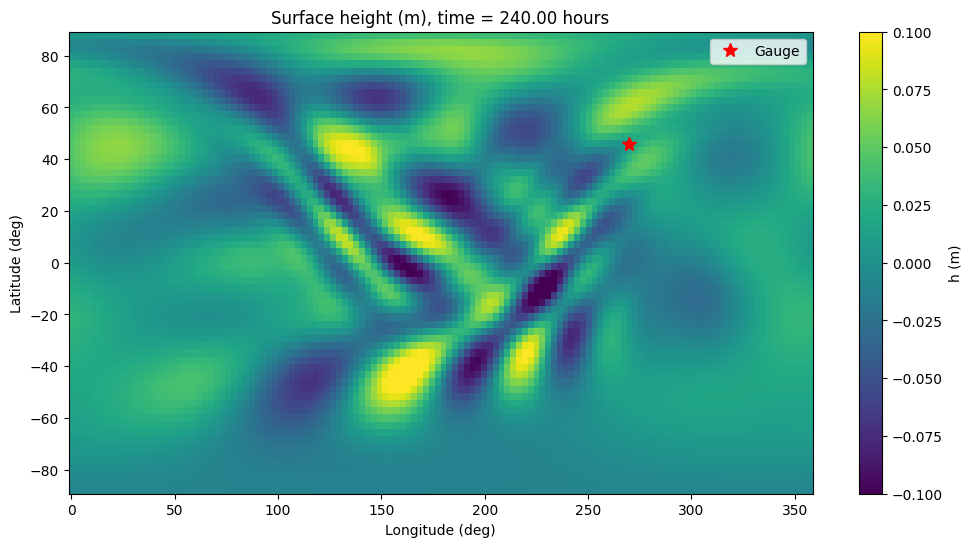

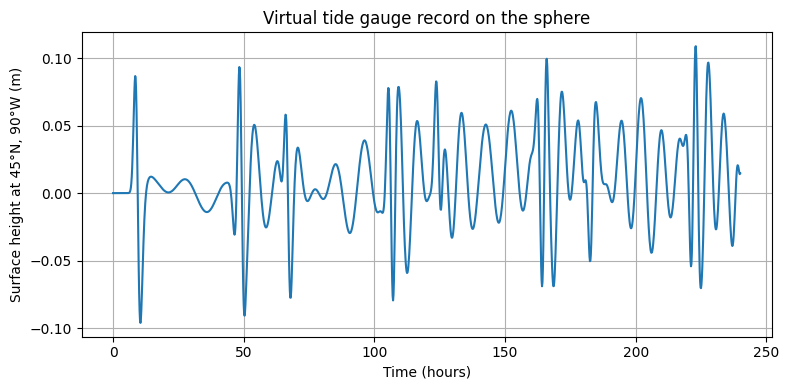

In [32]:

import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt

from dedalus.extras import plot_tools
from matplotlib import animation
from IPython.display import HTML

logger = logging.getLogger(__name__)


meter = 1
kilometer = 1e3 * meter
second = 1
minute = 60 * second
hour   = 3600 * second
day    = 24 * hour



Nphi   = 128
Ntheta = 64
R      = 6.37122e3 * kilometer
Omega  = 2 * np.pi / (1 * day)
g      = 9.80616 * meter / second**2
H      = 4 * kilometer

width  = 2*np.pi*10/360
phi0   = np.pi
theta0 = np.pi/4

timestep      = 600 * second
stop_sim_time = 10 * day


coords = dedalus.S2Coordinates('phi', 'theta')
dist   = dedalus.Distributor(coords, dtype=np.float64)
basis  = dedalus.SphereBasis(coords, (Nphi, Ntheta),
                             radius=R, dealias=3/2,
                             dtype=np.float64)
phi, theta = dist.local_grids(basis)


lat_deg = (np.pi/2 - theta) * 180/np.pi
lon_deg = phi * 180/np.pi
u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)


Grad   = lambda A: dedalus.grad(A)
Div    = lambda A: dedalus.div(A)
Zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))


h.change_scales(1)
u.change_scales(1)

h['g'] = np.exp(-((phi - phi0)**2 + (theta - theta0)**2) / width**2)

u['g'][0] = 0.0
u['g'][1] = 0.0


problem = dedalus.IVP(
    [u, h],
    namespace={
        'u': u, 'h': h,
        'g': g, 'H': H,
        'Omega': Omega,
        'Grad': Grad,
        'Div': Div,
        'Zcross': Zcross
    }
)


problem.add_equation("dt(u) + g*Grad(h) + 2*Omega*Zcross(u) = - u@Grad(u)")
problem.add_equation("dt(h) + H*Div(u) = - Div(h*u)")

solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time



target_lat = 45.0
target_lon = 270.0


lat_1d = lat_deg[0, :]
lon_1d = lon_deg[:, 0]

j_lat = np.argmin(np.abs(lat_1d - target_lat))
i_lon = np.argmin(np.abs(lon_1d - target_lon))

print("Gauge indices (i_lon, j_lat):", i_lon, j_lat)
print("Gauge actual location  (lat, lon) =",
      lat_1d[j_lat], lon_1d[i_lon])



h.change_scales(1)
h_save   = [np.copy(h['g'])]
t_save   = [solver.sim_time]
gauge_h  = [h['g'][i_lon, j_lat]]

try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)

        h.change_scales(1)

        h_save.append(np.copy(h['g']))
        t_save.append(solver.sim_time)
        gauge_h.append(h['g'][i_lon, j_lat])


        if (solver.iteration - 1) % 20 == 0:
            logger.info('Iteration=%i, Time=%e, dt=%e'
                        % (solver.iteration, solver.sim_time, timestep))

except Exception:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save  = np.array(h_save)
t_save  = np.array(t_save)
gauge_h = np.array(gauge_h)



fig = plt.figure(figsize=(12, 6))


X, Y = plot_tools.quad_mesh(np.squeeze(lon_1d), np.squeeze(lat_1d))

def drawframe(n):
    plt.clf()
    height = plt.pcolormesh(
        X, Y, h_save[n, :, :].T,
        vmin=-0.1, vmax=0.1,
        shading='auto'
    )
    plt.xlabel('Longitude (deg)')
    plt.ylabel('Latitude (deg)')
    plt.title('Surface height (m), time = {0:.2f} hours'
              .format(t_save[n] / hour))
    plt.colorbar(height, label='h (m)')
    plt.plot(lon_1d[i_lon], lat_1d[j_lat], 'r*', ms=10, label='Gauge')
    plt.legend(loc='upper right')
    return []

anim = animation.FuncAnimation(
    fig, drawframe,
    frames=len(t_save),
    interval=40,
    blit=False
)

HTML(anim.to_html5_video())


plt.figure(figsize=(8,4))
plt.plot(t_save/hour, gauge_h)
plt.xlabel('Time (hours)')
plt.ylabel('Surface height at 45°N, 90°W (m)')
plt.title('Virtual tide gauge record on the sphere')
plt.grid(True)
plt.tight_layout()
plt.show()


ADD PLOTS AND DISCUSSION HERE

In the simulation above, the Tsunami wave travels around the planet many times. In reality, the waves will partially dissipate when they reach shorelines. In the spherical shallow water equation code above (or in a new code block below), add a forcing term to the shallow water equations that damps the waves for longitudes larger than $\pm 90^\circ$. Specifically, add a forcing function to the right hand side of the height equation of the following form:

$$ - (1/\tau) f(\phi) h$$

where

$$ f(\phi) = \frac{1}{2}\left(1+tanh\left(\frac{\phi-3\pi/2}{\pi/10}\right)\right) + \frac{1}{2}\left(1-tanh\left(\frac{\phi-\pi/2}{\pi/10}\right)\right) $$

and $\phi$ is the longitude in radians and $\tau$ is a damping timescale. A timescale of $\tau=0.1$ days should be sufficient to damp the waves.

With this damping term active, much more slowly propagating waves should be visible. These are shallow water Rossby waves. Estimate the east/west phase speed of these Rossby waves from the theoretical dispersion relation and compare this estimate with the phase speed that you can infer from the simulation by plotting the height, $h$, as a function of longitude and time. Discuss the spatial structure of the Rossby waves and any discrepancies that you see between your estimated and measured phase speeds.

INFO:subsystems:Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 8.3e+01/s


2025-11-26 20:12:23,791 subsystems 0/1 INFO :: Building subproblem matrices 1/63 (~2%) Elapsed: 0s, Remaining: 1s, Rate: 8.3e+01/s


INFO:subsystems:Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 1.1e+02/s


2025-11-26 20:12:23,845 subsystems 0/1 INFO :: Building subproblem matrices 7/63 (~11%) Elapsed: 0s, Remaining: 1s, Rate: 1.1e+02/s


INFO:subsystems:Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s


2025-11-26 20:12:23,909 subsystems 0/1 INFO :: Building subproblem matrices 14/63 (~22%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s


INFO:subsystems:Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s


2025-11-26 20:12:23,972 subsystems 0/1 INFO :: Building subproblem matrices 21/63 (~33%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s


INFO:subsystems:Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s


2025-11-26 20:12:24,036 subsystems 0/1 INFO :: Building subproblem matrices 28/63 (~44%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s


INFO:subsystems:Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s


2025-11-26 20:12:24,105 subsystems 0/1 INFO :: Building subproblem matrices 35/63 (~56%) Elapsed: 0s, Remaining: 0s, Rate: 1.1e+02/s


INFO:subsystems:Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


2025-11-26 20:12:25,271 subsystems 0/1 INFO :: Building subproblem matrices 42/63 (~67%) Elapsed: 1s, Remaining: 1s, Rate: 2.8e+01/s


INFO:subsystems:Building subproblem matrices 49/63 (~78%) Elapsed: 2s, Remaining: 0s, Rate: 3.1e+01/s


2025-11-26 20:12:25,340 subsystems 0/1 INFO :: Building subproblem matrices 49/63 (~78%) Elapsed: 2s, Remaining: 0s, Rate: 3.1e+01/s


INFO:subsystems:Building subproblem matrices 56/63 (~89%) Elapsed: 2s, Remaining: 0s, Rate: 3.4e+01/s


2025-11-26 20:12:25,411 subsystems 0/1 INFO :: Building subproblem matrices 56/63 (~89%) Elapsed: 2s, Remaining: 0s, Rate: 3.4e+01/s


INFO:subsystems:Building subproblem matrices 63/63 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 3.7e+01/s


2025-11-26 20:12:25,483 subsystems 0/1 INFO :: Building subproblem matrices 63/63 (~100%) Elapsed: 2s, Remaining: 0s, Rate: 3.7e+01/s


INFO:__main__:Starting main loop


2025-11-26 20:12:25,489 __main__ 0/1 INFO :: Starting main loop


INFO:__main__:Iter=1  t=  0.01 days


2025-11-26 20:12:31,526 __main__ 0/1 INFO :: Iter=1  t=  0.01 days


INFO:__main__:Iter=51  t=  0.35 days


2025-11-26 20:12:33,581 __main__ 0/1 INFO :: Iter=51  t=  0.35 days


INFO:__main__:Iter=101  t=  0.70 days


2025-11-26 20:12:35,415 __main__ 0/1 INFO :: Iter=101  t=  0.70 days


INFO:__main__:Iter=151  t=  1.05 days


2025-11-26 20:12:37,322 __main__ 0/1 INFO :: Iter=151  t=  1.05 days


INFO:__main__:Iter=201  t=  1.40 days


2025-11-26 20:12:39,497 __main__ 0/1 INFO :: Iter=201  t=  1.40 days


INFO:__main__:Iter=251  t=  1.74 days


2025-11-26 20:12:41,940 __main__ 0/1 INFO :: Iter=251  t=  1.74 days


INFO:__main__:Iter=301  t=  2.09 days


2025-11-26 20:12:44,221 __main__ 0/1 INFO :: Iter=301  t=  2.09 days


INFO:__main__:Iter=351  t=  2.44 days


2025-11-26 20:12:46,350 __main__ 0/1 INFO :: Iter=351  t=  2.44 days


INFO:__main__:Iter=401  t=  2.78 days


2025-11-26 20:12:48,245 __main__ 0/1 INFO :: Iter=401  t=  2.78 days


INFO:__main__:Iter=451  t=  3.13 days


2025-11-26 20:12:50,105 __main__ 0/1 INFO :: Iter=451  t=  3.13 days


INFO:__main__:Iter=501  t=  3.48 days


2025-11-26 20:12:51,984 __main__ 0/1 INFO :: Iter=501  t=  3.48 days


INFO:__main__:Iter=551  t=  3.83 days


2025-11-26 20:12:54,384 __main__ 0/1 INFO :: Iter=551  t=  3.83 days


INFO:__main__:Iter=601  t=  4.17 days


2025-11-26 20:12:56,285 __main__ 0/1 INFO :: Iter=601  t=  4.17 days


INFO:__main__:Iter=651  t=  4.52 days


2025-11-26 20:12:58,319 __main__ 0/1 INFO :: Iter=651  t=  4.52 days


INFO:__main__:Iter=701  t=  4.87 days


2025-11-26 20:13:00,505 __main__ 0/1 INFO :: Iter=701  t=  4.87 days


INFO:__main__:Iter=751  t=  5.22 days


2025-11-26 20:13:02,379 __main__ 0/1 INFO :: Iter=751  t=  5.22 days


INFO:__main__:Iter=801  t=  5.56 days


2025-11-26 20:13:04,249 __main__ 0/1 INFO :: Iter=801  t=  5.56 days


INFO:__main__:Iter=851  t=  5.91 days


2025-11-26 20:13:06,706 __main__ 0/1 INFO :: Iter=851  t=  5.91 days


INFO:__main__:Iter=901  t=  6.26 days


2025-11-26 20:13:09,061 __main__ 0/1 INFO :: Iter=901  t=  6.26 days


INFO:__main__:Iter=951  t=  6.60 days


2025-11-26 20:13:10,939 __main__ 0/1 INFO :: Iter=951  t=  6.60 days


INFO:__main__:Iter=1001  t=  6.95 days


2025-11-26 20:13:12,862 __main__ 0/1 INFO :: Iter=1001  t=  6.95 days


INFO:__main__:Iter=1051  t=  7.30 days


2025-11-26 20:13:14,995 __main__ 0/1 INFO :: Iter=1051  t=  7.30 days


INFO:__main__:Iter=1101  t=  7.65 days


2025-11-26 20:13:17,427 __main__ 0/1 INFO :: Iter=1101  t=  7.65 days


INFO:__main__:Iter=1151  t=  7.99 days


2025-11-26 20:13:19,323 __main__ 0/1 INFO :: Iter=1151  t=  7.99 days


INFO:__main__:Iter=1201  t=  8.34 days


2025-11-26 20:13:21,787 __main__ 0/1 INFO :: Iter=1201  t=  8.34 days


INFO:__main__:Iter=1251  t=  8.69 days


2025-11-26 20:13:23,929 __main__ 0/1 INFO :: Iter=1251  t=  8.69 days


INFO:__main__:Iter=1301  t=  9.03 days


2025-11-26 20:13:26,365 __main__ 0/1 INFO :: Iter=1301  t=  9.03 days


INFO:__main__:Iter=1351  t=  9.38 days


2025-11-26 20:13:28,760 __main__ 0/1 INFO :: Iter=1351  t=  9.38 days


INFO:__main__:Iter=1401  t=  9.73 days


2025-11-26 20:13:30,814 __main__ 0/1 INFO :: Iter=1401  t=  9.73 days


INFO:__main__:Iter=1451  t= 10.08 days


2025-11-26 20:13:32,803 __main__ 0/1 INFO :: Iter=1451  t= 10.08 days


INFO:__main__:Iter=1501  t= 10.42 days


2025-11-26 20:13:34,684 __main__ 0/1 INFO :: Iter=1501  t= 10.42 days


INFO:__main__:Iter=1551  t= 10.77 days


2025-11-26 20:13:36,556 __main__ 0/1 INFO :: Iter=1551  t= 10.77 days


INFO:__main__:Iter=1601  t= 11.12 days


2025-11-26 20:13:38,681 __main__ 0/1 INFO :: Iter=1601  t= 11.12 days


INFO:__main__:Iter=1651  t= 11.47 days


2025-11-26 20:13:41,176 __main__ 0/1 INFO :: Iter=1651  t= 11.47 days


INFO:__main__:Iter=1701  t= 11.81 days


2025-11-26 20:13:43,082 __main__ 0/1 INFO :: Iter=1701  t= 11.81 days


INFO:__main__:Iter=1751  t= 12.16 days


2025-11-26 20:13:45,117 __main__ 0/1 INFO :: Iter=1751  t= 12.16 days


INFO:__main__:Iter=1801  t= 12.51 days


2025-11-26 20:13:47,413 __main__ 0/1 INFO :: Iter=1801  t= 12.51 days


INFO:__main__:Iter=1851  t= 12.85 days


2025-11-26 20:13:49,318 __main__ 0/1 INFO :: Iter=1851  t= 12.85 days


INFO:__main__:Iter=1901  t= 13.20 days


2025-11-26 20:13:51,605 __main__ 0/1 INFO :: Iter=1901  t= 13.20 days


INFO:__main__:Iter=1951  t= 13.55 days


2025-11-26 20:13:53,615 __main__ 0/1 INFO :: Iter=1951  t= 13.55 days


INFO:__main__:Iter=2001  t= 13.90 days


2025-11-26 20:13:55,558 __main__ 0/1 INFO :: Iter=2001  t= 13.90 days


INFO:__main__:Iter=2051  t= 14.24 days


2025-11-26 20:13:57,479 __main__ 0/1 INFO :: Iter=2051  t= 14.24 days


INFO:__main__:Iter=2101  t= 14.59 days


2025-11-26 20:13:59,487 __main__ 0/1 INFO :: Iter=2101  t= 14.59 days


INFO:__main__:Iter=2151  t= 14.94 days


2025-11-26 20:14:01,554 __main__ 0/1 INFO :: Iter=2151  t= 14.94 days


INFO:__main__:Iter=2201  t= 15.28 days


2025-11-26 20:14:03,928 __main__ 0/1 INFO :: Iter=2201  t= 15.28 days


INFO:__main__:Iter=2251  t= 15.63 days


2025-11-26 20:14:05,777 __main__ 0/1 INFO :: Iter=2251  t= 15.63 days


INFO:__main__:Iter=2301  t= 15.98 days


2025-11-26 20:14:07,607 __main__ 0/1 INFO :: Iter=2301  t= 15.98 days


INFO:__main__:Iter=2351  t= 16.33 days


2025-11-26 20:14:09,570 __main__ 0/1 INFO :: Iter=2351  t= 16.33 days


INFO:__main__:Iter=2401  t= 16.67 days


2025-11-26 20:14:11,648 __main__ 0/1 INFO :: Iter=2401  t= 16.67 days


INFO:__main__:Iter=2451  t= 17.02 days


2025-11-26 20:14:13,692 __main__ 0/1 INFO :: Iter=2451  t= 17.02 days


INFO:__main__:Iter=2501  t= 17.37 days


2025-11-26 20:14:16,276 __main__ 0/1 INFO :: Iter=2501  t= 17.37 days


INFO:__main__:Iter=2551  t= 17.72 days


2025-11-26 20:14:18,228 __main__ 0/1 INFO :: Iter=2551  t= 17.72 days


INFO:__main__:Iter=2601  t= 18.06 days


2025-11-26 20:14:20,648 __main__ 0/1 INFO :: Iter=2601  t= 18.06 days


INFO:__main__:Iter=2651  t= 18.41 days


2025-11-26 20:14:22,583 __main__ 0/1 INFO :: Iter=2651  t= 18.41 days


INFO:__main__:Iter=2701  t= 18.76 days


2025-11-26 20:14:24,484 __main__ 0/1 INFO :: Iter=2701  t= 18.76 days


INFO:__main__:Iter=2751  t= 19.10 days


2025-11-26 20:14:26,968 __main__ 0/1 INFO :: Iter=2751  t= 19.10 days


INFO:__main__:Iter=2801  t= 19.45 days


2025-11-26 20:14:29,022 __main__ 0/1 INFO :: Iter=2801  t= 19.45 days


INFO:__main__:Iter=2851  t= 19.80 days


2025-11-26 20:14:30,907 __main__ 0/1 INFO :: Iter=2851  t= 19.80 days


INFO:solvers:Simulation stop time reached.


2025-11-26 20:14:32,005 solvers 0/1 INFO :: Simulation stop time reached.


INFO:solvers:Final iteration: 2880


2025-11-26 20:14:32,006 solvers 0/1 INFO :: Final iteration: 2880


INFO:solvers:Final sim time: 1728000.0


2025-11-26 20:14:32,009 solvers 0/1 INFO :: Final sim time: 1728000.0


INFO:solvers:Setup time (init - iter 0): 1.738 sec


2025-11-26 20:14:32,011 solvers 0/1 INFO :: Setup time (init - iter 0): 1.738 sec


INFO:solvers:Warmup time (iter 0-10): 6.571 sec


2025-11-26 20:14:32,013 solvers 0/1 INFO :: Warmup time (iter 0-10): 6.571 sec


INFO:solvers:Run time (iter 10-end): 119.9 sec


2025-11-26 20:14:32,016 solvers 0/1 INFO :: Run time (iter 10-end): 119.9 sec


INFO:solvers:CPU time (iter 10-end): 0.03332 cpu-hr


2025-11-26 20:14:32,018 solvers 0/1 INFO :: CPU time (iter 10-end): 0.03332 cpu-hr


INFO:solvers:Speed: 5.786e+05 mode-stages/cpu-sec


2025-11-26 20:14:32,021 solvers 0/1 INFO :: Speed: 5.786e+05 mode-stages/cpu-sec
Hovmöller latitude index j = 42,  actual lat = 29.30°


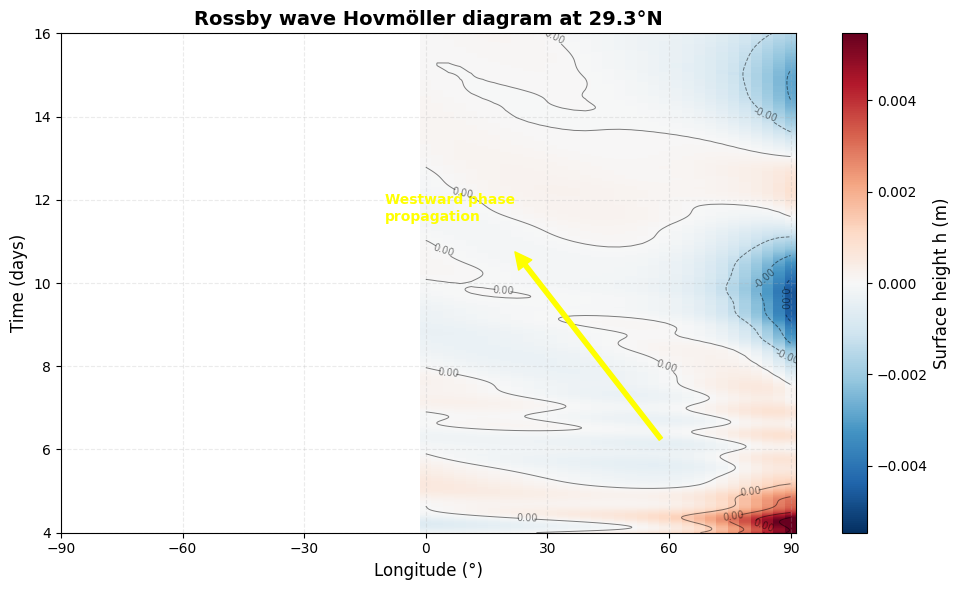

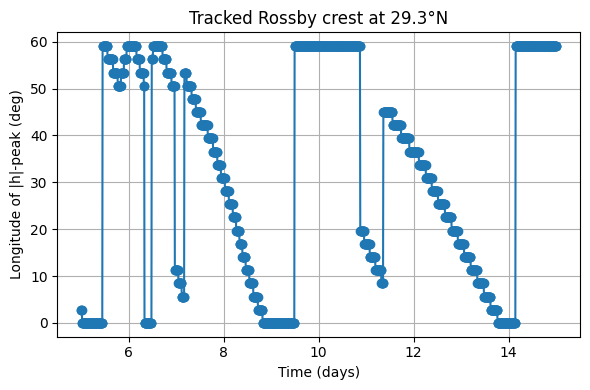


==== Numerical phase speed from fit ====
Fitted slope d(lon)/dt = -0.210 deg/day
Numerical phase speed c_num = -0.236 m/s

==== Theoretical Rossby speed (β-plane) ====
Assumed zonal wavelength λ_x = 5818.3 km
Deformation radius Rd       = 2782.4 km
Theoretical phase speed c_theory = -15.368 m/s

==== Numerical vs Theoretical comparison ====
Numerical  c_num     = -0.236 m/s
Theoretical c_theory = -15.368 m/s
Difference (num - theory) = 15.132 m/s


In [37]:
# ADD CODE HERE TO SOLVE THE SHALLOW WATER EQUATIONS WITH DAMPING.
# YOU CAN START BY COPYING THE CODE ABOVE AND PASTING IT HERE

import numpy as np
import dedalus.public as dedalus
import logging
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

logger = logging.getLogger(__name__)


meter = 1.0
kilometer = 1e3 * meter
second = 1.0
minute = 60 * second
hour   = 3600 * second
day    = 24 * hour


Nphi   = 128
Ntheta = 64
R      = 6.37122e3 * kilometer
Omega  = 2*np.pi / day
g      = 9.80616 * meter / second**2
H      = 4 * kilometer


width  = 2*np.pi*10/360
phi0   = np.pi
theta0 = np.pi/4

timestep      = 600 * second
stop_sim_time = 20 * day


tau = 0.1 * day

coords = dedalus.S2Coordinates('phi', 'theta')
dist   = dedalus.Distributor(coords, dtype=np.float64)
basis  = dedalus.SphereBasis(coords, (Nphi, Ntheta),
                             radius=R, dealias=3/2,
                             dtype=np.float64)

phi, theta = dist.local_grids(basis)


lat_deg = (np.pi/2 - theta) * 180/np.pi
lon_deg = phi * 180/np.pi


lat_1d = lat_deg[0, :]
lon_1d = lon_deg[:, 0]

u = dist.VectorField(coords, name='u', bases=basis)
h = dist.Field(name='h', bases=basis)


Grad   = lambda A: dedalus.grad(A)
Div    = lambda A: dedalus.div(A)
Zcross = lambda A: dedalus.MulCosine(dedalus.skew(A))


u.change_scales(1)
h.change_scales(1)


h['g'] = np.exp(-((phi - phi0)**2 + (theta - theta0)**2) / width**2)


u['g'][0] = 0.0
u['g'][1] = 0.0


fphi = dist.Field(name='fphi', bases=basis)
fphi.change_scales(1)

fphi['g'] = 0.5 * (1 + np.tanh((phi - 3*np.pi/2)/(np.pi/10))) \
          + 0.5 * (1 - np.tanh((phi -   np.pi/2)/(np.pi/10)))


problem = dedalus.IVP(
    [u, h],
    namespace={
        'u': u, 'h': h,
        'g': g, 'H': H,
        'Omega': Omega,
        'Grad': Grad, 'Div': Div, 'Zcross': Zcross,
        'fphi': fphi, 'tau': tau
    }
)


problem.add_equation("dt(u) + g*Grad(h) + 2*Omega*Zcross(u) = - u@Grad(u)")
problem.add_equation("dt(h) + H*Div(u) = - Div(h*u) - (1/tau)*fphi*h")


solver = problem.build_solver(dedalus.RK222)
solver.stop_sim_time = stop_sim_time

h.change_scales(1)
h_save = [np.copy(h['g'])]
t_save = [solver.sim_time]

try:
    logger.info('Starting main loop')
    while solver.proceed:
        solver.step(timestep)
        h.change_scales(1)
        h_save.append(np.copy(h['g']))
        t_save.append(solver.sim_time)

        if (solver.iteration-1) % 50 == 0:
            logger.info('Iter=%i  t=%6.2f days'
                        % (solver.iteration, solver.sim_time/day))

except Exception:
    logger.error('Exception raised, triggering end of main loop.')
    raise
finally:
    solver.log_stats()

h_save = np.array(h_save)
t_save = np.array(t_save)
t_days = t_save / day
Nt     = len(t_days)


target_lat = 29.3
j_lat = np.argmin(np.abs(lat_1d - target_lat))

print(f"Hovmöller latitude index j = {j_lat},  actual lat = {lat_1d[j_lat]:.2f}°")


hov = h_save[:, :, j_lat]


t_min_plot   = 4.0
t_max_plot   = 16.0
lon_min_plot = -90.0
lon_max_plot =  90.0

it_min_plot = np.argmin(np.abs(t_days - t_min_plot))
it_max_plot = np.argmin(np.abs(t_days - t_max_plot)) + 1
ilon_min_plot = np.argmin(np.abs(lon_1d - lon_min_plot))
ilon_max_plot = np.argmin(np.abs(lon_1d - lon_max_plot)) + 1

hov_plot = hov[it_min_plot:it_max_plot, ilon_min_plot:ilon_max_plot]
t_plot   = t_days[it_min_plot:it_max_plot]
lon_plot = lon_1d[ilon_min_plot:ilon_max_plot]

Tg, Lg = np.meshgrid(t_plot, lon_plot, indexing='ij')


vmax = np.max(np.abs(hov_plot)) * 0.9
norm = TwoSlopeNorm(vcenter=0.0, vmin=-vmax, vmax=vmax)

plt.figure(figsize=(10, 6))
pcm = plt.pcolormesh(Lg, Tg, hov_plot,
                     shading='auto',
                     cmap='RdBu_r',
                     norm=norm)

levels = np.linspace(-vmax, vmax, 9)
CS = plt.contour(Lg, Tg, hov_plot, levels=levels,
                 colors='k', linewidths=0.7, alpha=0.5)
plt.clabel(CS, inline=True, fontsize=7, fmt="%.02f")

cbar = plt.colorbar(pcm)
cbar.set_label("Surface height h (m)", fontsize=12)

plt.xlabel("Longitude (°)", fontsize=12)
plt.ylabel("Time (days)", fontsize=12)
plt.title("Rossby wave Hovmöller diagram at %.1f°N" % lat_1d[j_lat],
          fontsize=14, weight='bold')
plt.xticks(np.arange(-90, 91, 30))
plt.grid(alpha=0.25, linestyle='--')


arrow_lon = 60.0
t1, t2 = 6.0, 11.0
plt.annotate('', xy=(arrow_lon-40, t2),
             xytext=(arrow_lon, t1),
             arrowprops=dict(facecolor='yellow',
                             edgecolor='yellow',
                             shrink=0.05,
                             width=3,
                             headwidth=12))
plt.text(arrow_lon-70, t2+0.5,
         "Westward phase\npropagation",
         fontsize=10, color='yellow', weight='bold')

plt.tight_layout()
plt.show()


t_min_fit   = 5.0
t_max_fit   = 15.0
lon_min_fit = -60.0
lon_max_fit =  60.0

it_min = np.argmin(np.abs(t_days - t_min_fit))
it_max = np.argmin(np.abs(t_days - t_max_fit)) + 1
ilon_min = np.argmin(np.abs(lon_1d - lon_min_fit))
ilon_max = np.argmin(np.abs(lon_1d - lon_max_fit)) + 1

hov_win = hov[it_min:it_max, ilon_min:ilon_max]
t_win   = t_days[it_min:it_max]
lon_win = lon_1d[ilon_min:ilon_max]

lon_peak = []
t_peak   = []


for n in range(hov_win.shape[0]):
    row = hov_win[n, :]
    jmax = np.argmax(np.abs(row))
    lon_peak.append(lon_win[jmax])
    t_peak.append(t_win[n])

lon_peak = np.array(lon_peak)
t_peak   = np.array(t_peak)


plt.figure(figsize=(6,4))
plt.plot(t_peak, lon_peak, 'o-')
plt.xlabel('Time (days)')
plt.ylabel('Longitude of |h|-peak (deg)')
plt.title('Tracked Rossby crest at %.1f°N' % lat_1d[j_lat])
plt.grid(True)
plt.tight_layout()
plt.show()


coef = np.polyfit(t_peak, lon_peak, 1)
a_fit, b_fit = coef

print("\n==== Numerical phase speed from fit ====")
print("Fitted slope d(lon)/dt = %.3f deg/day" % a_fit)

lat0_deg = lat_1d[j_lat]
lat0_rad = np.deg2rad(lat0_deg)

dx_per_deg = (np.pi/180.0) * R * np.cos(lat0_rad)
c_num = a_fit * dx_per_deg / (24*3600)

print("Numerical phase speed c_num = %.3f m/s" % c_num)


lambda_lon_deg = 60.0
lambda_x = lambda_lon_deg * (np.pi/180.0) * R * np.cos(lat0_rad)

beta = 2 * Omega * np.cos(lat0_rad) / R
f0   = 2 * Omega * np.sin(lat0_rad)

c_grav = np.sqrt(g * H)
Rd     = c_grav / np.abs(f0)

k = 2*np.pi / lambda_x

c_theory = - beta / (k**2 + 1/Rd**2)

print("\n==== Theoretical Rossby speed (β-plane) ====")
print("Assumed zonal wavelength λ_x = %.1f km" % (lambda_x/1000))
print("Deformation radius Rd       = %.1f km" % (Rd/1000))
print("Theoretical phase speed c_theory = %.3f m/s" % c_theory)

print("\n==== Numerical vs Theoretical comparison ====")
print("Numerical  c_num     = %.3f m/s" % c_num)
print("Theoretical c_theory = %.3f m/s" % c_theory)
print("Difference (num - theory) = %.3f m/s" % (c_num - c_theory))



## 4. Optional further investigations

* In the example of the shallow water equations on a sphere, introduce bathymetry by making $H$ a function of latitude and longitude. Make sure that you modify the equations in Dedalus appropriately. How do the waves behave when they encounter shallow water (e.g. a localized seamount)?

* It is quite difficult to simulate changing sea level (sometimes called wetting and drying), which is why the examples above do not include land. However, we can estimate the distance that a Tsunami will propagate using physical and dimensional arguments. Consider, for example, a flat, sloping beach. In the absence of energy dissipation, estimate the distance that a wave will propagate onshore. How could you modify this estimate to include energy dissipation (or drag)?